# Modelado Predictivo Comparativo: Bucaramanga vs Santa Marta - Pruebas Saber 11

Este notebook implementa y compara diferentes algoritmos de aprendizaje automático para predecir el puntaje de matemáticas en las pruebas Saber 11 utilizando Apache Spark, **con análisis diferenciado por municipio**.

## Objetivo

El objetivo principal es **identificar los factores socioeconómicos que más influyen en el rendimiento académico en matemáticas**, comparando dos contextos urbanos distintos: Bucaramanga y Santa Marta. 

### Preguntas de Investigación

1. ¿Qué variables socioeconómicas predicen mejor el rendimiento en matemáticas en cada municipio?
2. ¿Existen diferencias en la importancia relativa de las variables entre ambas ciudades?
3. ¿Pueden estas diferencias explicar las brechas de rendimiento observadas?

### Estrategia Metodológica

- **Análisis separado por municipio**: Entrenamiento de modelos independientes para Bucaramanga y Santa Marta
- **Comparación de importancia de variables**: Uso de SHAP values para identificar factores diferenciales
- **Modelos múltiples**: Comparación entre regresión lineal (modelo clásico) y algoritmos de machine learning

## Configuración del Entorno

### Modo de Ejecución: Local en Windows

Para este proyecto configuré Spark en modo local, lo que permite ejecutar el código en un equipo personal sin necesidad de un cluster dedicado. Esta configuración tiene las siguientes características:

- Procesamiento en un solo equipo con recursos limitados (8-16GB RAM típicamente)
- Utilización de métodos Pandas para exportación de datos, evitando dependencias de Hadoop en Windows
- Análisis simplificado de particiones adaptado al entorno local
- Tiempo de ejecución estimado: 2-4 horas dependiendo del hardware (análisis dual)

### Datos de Entrada

El análisis se basa en el dataset limpio procesado en etapas anteriores:
- `datos/saber_11_limpio_final.csv`: Dataset con limpieza aplicada que contiene datos de **Bucaramanga** y **Santa Marta**

### Prerequisitos

Antes de ejecutar este notebook, verifiqué que se cumplieran las siguientes condiciones:
1. Ejecución previa del notebook `Limpieza_Saber11.ipynb` para generar el dataset limpio
2. Existencia del archivo `datos/saber_11_limpio_final.csv` con ambos municipios
3. Instalación correcta de PySpark, SHAP y dependencias asociadas

## Modelos Implementados (Por Municipio)

Para cada municipio (Bucaramanga y Santa Marta) entreno y comparo tres algoritmos:

### Modelo Estadístico Clásico
1. **Regresión Lineal con Regularización**: Modelo interpretable que permite identificar relaciones lineales entre variables socioeconómicas y rendimiento

### Modelos de Machine Learning
2. **Random Forest Regressor**: Ensamble de árboles de decisión que captura interacciones no lineales
3. **Gradient Boosted Trees (GBT)**: Ensamble secuencial optimizado para precisión predictiva

## Métricas de Evaluación

Para evaluar el desempeño de cada modelo utilicé las siguientes métricas estándar:
- **RMSE** (Root Mean Squared Error): Error cuadrático medio raíz
- **MAE** (Mean Absolute Error): Error absoluto medio
- **R²** (R-squared): Coeficiente de determinación
- **MSE** (Mean Squared Error): Error cuadrático medio

## Análisis de Interpretabilidad (SHAP)

Utilizo **SHAP (SHapley Additive exPlanations)** para:
- Identificar las variables más influyentes en cada municipio
- Comparar la importancia relativa de factores socioeconómicos entre ciudades
- Detectar factores diferenciales que expliquen brechas de rendimiento

## 1. Inicialización de Apache Spark

En esta sección configuro la sesión de Spark con parámetros optimizados para procesamiento en modo local.

In [1]:
# Importación de librerías necesarias para Spark y procesamiento de datos
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
import warnings
warnings.filterwarnings('ignore')

# Configuración de la sesión Spark con parámetros optimizados para ejecución local
# La configuración incluye ajustes de memoria y paralelismo adaptados al hardware disponible
spark = (SparkSession.builder
         .appName('Saber11_Modelos_Predictivos')
         .config('spark.driver.memory', '8g')
         .config('spark.executor.memory', '16g')
         .config('spark.executor.cores', '8')
         .config('spark.sql.shuffle.partitions', '400')
         .config('spark.default.parallelism', '400')
         .config('spark.sql.adaptive.enabled', 'true')
         .config('spark.sql.adaptive.coalescePartitions.enabled', 'true')
         .config('spark.network.timeout', '1200s')
         .config('spark.executor.heartbeatInterval', '120s')
         .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')
         .config('spark.kryoserializer.buffer.max', '512m')
         .getOrCreate())

# Verificación de la configuración de Spark
print("=" * 70)
print("SPARK INICIADO CORRECTAMENTE")
print("=" * 70)
print(f"Versión de Spark: {spark.version}")
print(f"ID de Aplicación: {spark.sparkContext.applicationId}")
print(f"Master: {spark.sparkContext.master}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")
print(f"Paralelismo por defecto: {spark.sparkContext.defaultParallelism}")
print("=" * 70)

SPARK INICIADO CORRECTAMENTE
Versión de Spark: 4.0.0
ID de Aplicación: local-1768859104252
Master: local[*]
Spark UI: http://MSI:4040
Paralelismo por defecto: 400


## 2. Carga y Separación de Datos por Municipio

En esta etapa cargo el dataset previamente limpiado y **separo los datos de Bucaramanga y Santa Marta** para realizar análisis independientes. Esta separación es crítica para identificar factores diferenciales que expliquen las brechas de rendimiento entre ambas ciudades.

In [2]:
from pathlib import Path

print("="*70)
print("CARGA DE DATOS DESDE ARCHIVO CSV")
print("="*70)

root_dir = Path.cwd()
base_dir = root_dir / "Modelos_Prediccion_Icfes-11"
if not base_dir.exists():
    base_dir = root_dir

csv_path = base_dir / "datos" / "saber_11_limpio_final.csv"
print(f"Ruta del archivo: {csv_path}")

print()
print("Caracteristicas del dataset:")
print("   - Duplicados previamente eliminados")
print("   - Tratamiento de valores nulos aplicado")
print("   - Columnas irrelevantes removidas")
print("   - Valores categoricos estandarizados")

if not csv_path.exists():
    raise FileNotFoundError(f"No se encontro el archivo: {csv_path}")

sdf = (spark.read
       .option("header", True)
       .option("inferSchema", True)
       .csv(str(csv_path)))

print()
print("Carga completada exitosamente")
print(f"Particiones iniciales: {sdf.rdd.getNumPartitions()}")

print()
print("Optimizando distribucion de datos...")
target_partitions = 400
print(f"Reparticionando a {target_partitions} particiones...")
sdf = sdf.repartition(target_partitions)

sdf.cache()
total_rows = sdf.count()

print()
print("DATOS LISTOS PARA PROCESAMIENTO")
print(f"   Total de registros: {total_rows:,}")
print(f"   Particiones distribuidas: {sdf.rdd.getNumPartitions()}")
print(f"   Columnas disponibles: {len(sdf.columns)}")
print("   Datos almacenados en cache")

print()
print("="*70)
print("DISTRIBUCION POR MUNICIPIO")
print("="*70)
sdf.groupBy("municipio").count().orderBy("municipio").show()

print()
print("="*70)
print("ESTRUCTURA DEL DATAFRAME")
print("="*70)
sdf.printSchema()

print()
print("="*70)
print("BALANCE DE PARTICIONES")
print("="*70)

if spark.sparkContext.master.startswith("local"):
    print("   Analisis de particiones deshabilitado en modo local")
    print("   Esta funcionalidad es relevante unicamente en entornos cluster")
else:
    partition_counts = sdf.rdd.mapPartitions(lambda it: [sum(1 for _ in it)]).collect()
    print(f"   Particiones: {len(partition_counts)}")
    print(f"   Min/Max por particion: {min(partition_counts)} / {max(partition_counts)}")

print("="*70)

print()
print("="*70)
print("SEPARACION DE DATOS POR MUNICIPIO")
print("="*70)

sdf_bucaramanga = sdf.filter(F.col("municipio") == "BUCARAMANGA").cache()
sdf_santamarta = sdf.filter(F.col("municipio") == "SANTA MARTA").cache()

count_bga = sdf_bucaramanga.count()
count_stm = sdf_santamarta.count()
total = count_bga + count_stm

print()
print("DISTRIBUCION DE DATOS:")
print(f"   - Bucaramanga: {count_bga:,} registros ({count_bga / total * 100:.1f}%)")
print(f"   - Santa Marta: {count_stm:,} registros ({count_stm / total * 100:.1f}%)")
print(f"   - Total: {total:,} registros")

print()
print("Datasets separados y almacenados en cache")
print("   Variables: sdf_bucaramanga, sdf_santamarta")
print("="*70)


CARGA DE DATOS DESDE ARCHIVO CSV
Ruta del archivo: c:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\datos\saber_11_limpio_final.csv

Caracteristicas del dataset:
   - Duplicados previamente eliminados
   - Tratamiento de valores nulos aplicado
   - Columnas irrelevantes removidas
   - Valores categoricos estandarizados

Carga completada exitosamente
Particiones iniciales: 19

Optimizando distribucion de datos...
Reparticionando a 400 particiones...

DATOS LISTOS PARA PROCESAMIENTO
   Total de registros: 217,335
   Particiones distribuidas: 400
   Columnas disponibles: 47
   Datos almacenados en cache

DISTRIBUCION POR MUNICIPIO
+-----------+------+
|  municipio| count|
+-----------+------+
|BUCARAMANGA|124609|
|SANTA MARTA| 92726|
+-----------+------+


ESTRUCTURA DEL DATAFRAME
root
 |-- periodo: integer (nullable = true)
 |-- estu_consecutivo: string (nullable = true)
 |-- estu_estudiante: string (nullable = true)
 |-- cole_area_ubicacion: string (null

In [3]:
# Exploración inicial de las características del dataset
print('EXPLORACIÓN INICIAL DEL DATASET')
print('='*60)
print(f"Total de registros cargados: {sdf.count():,}")
print(f"Total de columnas/variables: {len(sdf.columns)}")

# Análisis de la distribución temporal de los datos
print("\nDistribución de registros por periodo:")
sdf.groupBy('periodo').count().orderBy('periodo').show()

EXPLORACIÓN INICIAL DEL DATASET
Total de registros cargados: 217,335
Total de columnas/variables: 47

Distribución de registros por periodo:
+-------+-----+
|periodo|count|
+-------+-----+
|  20142|15801|
|  20151| 6034|
|  20152|15693|
|  20161| 4135|
|  20162|16027|
|  20171| 4715|
|  20172|15885|
|  20181| 3684|
|  20182|17009|
|  20191| 4009|
|  20192|17236|
|  20201| 2602|
|  20202|14928|
|  20211| 2670|
|  20212|16458|
|  20221| 3824|
|  20222|15783|
|  20231| 4689|
|  20232|16052|
|  20241| 4834|
+-------+-----+
only showing top 20 rows


## 3. Ingeniería de Características y Preparación para Modelado

En esta sección crítica del proyecto realizo el preprocesamiento completo de las variables para convertir los datasets de **Bucaramanga y Santa Marta** en formato adecuado para los algoritmos de machine learning. 

**Nota importante:** La variable `municipio` **NO se incluye** como feature predictivo, ya que el objetivo es analizar cómo las variables socioeconómicas explican las diferencias de rendimiento entre ciudades, no usar la ciudad como predictor directo.

Este proceso incluye:

- Identificación y categorización de variables según su naturaleza estadística
- Codificación de variables categóricas mediante técnicas apropiadas  
- Normalización y escalamiento de variables numéricas
- Tratamiento estratégico de valores faltantes
- Construcción del vector de características final
- División de datos en conjuntos de entrenamiento y prueba (70/30)

La preparación adecuada de las características es fundamental para el éxito de los modelos predictivos y la interpretabilidad de resultados.

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, 
    StandardScaler, Imputer
)
from pyspark.sql import functions as F

# Definición de la variable objetivo (target)
target_col = 'punt_matematicas'

# Clasificación de variables según su naturaleza estadística
numeric_cols = ['anio', 'p']
binary_cols = [
    'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet',
    'fami_tienelavadora', 'fami_tieneserviciotv', 'cole_bilingue'
]
# NOTA: Se EXCLUYE 'municipio' ya que estamos analizando cada ciudad por separado
nominal_cols = [
    'estu_genero', 'cole_naturaleza', 'cole_jornada', 'cole_area_ubicacion'
]
ordinal_cols = [
    'fami_estratovivienda', 'fami_cuartoshogar', 'fami_personashogar',
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_numlibros'
]

print("="*70)
print("PREPARACIÓN DE FEATURES - CONFIGURACIÓN")
print("="*70)
print(f"Variable objetivo: {target_col}")
print(f"\nCategorías de variables:")
print(f"  • Numéricas continuas: {len(numeric_cols)} variables")
print(f"  • Binarias: {len(binary_cols)} variables")
print(f"  • Categóricas nominales: {len(nominal_cols)} variables (municipio EXCLUIDO)")
print(f"  • Categóricas ordinales: {len(ordinal_cols)} variables")
print(f"\nTotal de features: {len(numeric_cols) + len(binary_cols) + len(nominal_cols) + len(ordinal_cols)}")
print("="*70)

# ============================================================================
# CONSTRUCCIÓN DEL PIPELINE DE TRANSFORMACIÓN
# ============================================================================
stages = []

# Etapa 1: Procesamiento de variables numéricas
imputer_num = Imputer(
    inputCols=numeric_cols,
    outputCols=[f"{c}_imputed" for c in numeric_cols],
    strategy="mean"
)
assembler_num = VectorAssembler(
    inputCols=imputer_num.getOutputCols(),
    outputCol="numeric_features_raw"
)
scaler = StandardScaler(
    inputCol="numeric_features_raw",
    outputCol="scaled_numeric_features",
    withStd=True, 
    withMean=False
)
stages.extend([imputer_num, assembler_num, scaler])

# Etapa 2: Procesamiento de variables binarias
imputer_bin = Imputer(
    inputCols=binary_cols,
    outputCols=[f"{c}_imputed" for c in binary_cols],
    strategy="mode"
)
stages.append(imputer_bin)

# Etapa 3: Procesamiento de variables categóricas nominales
indexers_nom = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep') 
    for c in nominal_cols
]
encoders_nom = [
    OneHotEncoder(inputCol=f"{c}_indexed", outputCol=f"{c}_encoded", dropLast=True)
    for c in nominal_cols
]
stages.extend(indexers_nom + encoders_nom)

# Etapa 4: Procesamiento de variables categóricas ordinales
indexers_ord = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep')
    for c in ordinal_cols
]
stages.extend(indexers_ord)

# Etapa 5: Ensamblaje final del vector de características
scaled_num_col = ["scaled_numeric_features"]
imputed_bin_cols = imputer_bin.getOutputCols()
encoded_nom_cols = [f"{c}_encoded" for c in nominal_cols]
indexed_ord_cols = [f"{c}_indexed" for c in ordinal_cols]
assembler_inputs = scaled_num_col + imputed_bin_cols + encoded_nom_cols + indexed_ord_cols
final_assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features",
    handleInvalid='skip'
)
stages.append(final_assembler)

# Crear pipeline
prep_pipeline = Pipeline(stages=stages)

print("\n" + "="*70)
print("ENTRENAMIENTO DE PIPELINES DE PREPARACIÓN (POR MUNICIPIO)")
print("="*70)

# ============================================================================
# PIPELINE PARA BUCARAMANGA
# ============================================================================
print("\n📍 BUCARAMANGA:")
print("-" * 70)

df_model_bucaramanga = sdf_bucaramanga.select(numeric_cols + binary_cols + nominal_cols + ordinal_cols + [target_col])

# Preprocesamiento de variables binarias
for col_name in binary_cols:
    df_model_bucaramanga = df_model_bucaramanga.withColumn(
        col_name,
        F.when(F.col(col_name).isin('Si', 'S'), 1.0)
         .when(F.col(col_name).isin('No', 'N'), 0.0)
         .otherwise(None)
    )

df_model_bucaramanga = df_model_bucaramanga.dropna(subset=[target_col])
df_model_bucaramanga.cache()
print(f"Registros válidos: {df_model_bucaramanga.count():,}")

prep_model_bucaramanga = prep_pipeline.fit(df_model_bucaramanga)
df_prepared_bucaramanga = prep_model_bucaramanga.transform(df_model_bucaramanga)
df_final_bucaramanga = df_prepared_bucaramanga.select('features', target_col).withColumnRenamed(target_col, 'label')

train_bucaramanga, test_bucaramanga = df_final_bucaramanga.randomSplit([0.7, 0.3], seed=42)
train_bucaramanga.cache()
test_bucaramanga.cache()

print(f"   • Entrenamiento: {train_bucaramanga.count():,} registros (70%)")
print(f"   • Prueba: {test_bucaramanga.count():,} registros (30%)")

# ============================================================================
# PIPELINE PARA SANTA MARTA
# ============================================================================
print("\n📍 SANTA MARTA:")
print("-" * 70)

df_model_santamarta = sdf_santamarta.select(numeric_cols + binary_cols + nominal_cols + ordinal_cols + [target_col])

# Preprocesamiento de variables binarias
for col_name in binary_cols:
    df_model_santamarta = df_model_santamarta.withColumn(
        col_name,
        F.when(F.col(col_name).isin('Si', 'S'), 1.0)
         .when(F.col(col_name).isin('No', 'N'), 0.0)
         .otherwise(None)
    )

df_model_santamarta = df_model_santamarta.dropna(subset=[target_col])
df_model_santamarta.cache()
print(f"Registros válidos: {df_model_santamarta.count():,}")

prep_model_santamarta = prep_pipeline.fit(df_model_santamarta)
df_prepared_santamarta = prep_model_santamarta.transform(df_model_santamarta)
df_final_santamarta = df_prepared_santamarta.select('features', target_col).withColumnRenamed(target_col, 'label')

train_santamarta, test_santamarta = df_final_santamarta.randomSplit([0.7, 0.3], seed=42)
train_santamarta.cache()
test_santamarta.cache()

print(f"   • Entrenamiento: {train_santamarta.count():,} registros (70%)")
print(f"   • Prueba: {test_santamarta.count():,} registros (30%)")

print("\n" + "="*70)
print("RESUMEN DE PREPARACIÓN")
print("="*70)
print(f"✅ Pipelines completados para ambos municipios")
print(f"✅ Datos divididos en train/test (70/30)")
print(f"✅ Variables almacenadas en cache")
print("="*70)

PREPARACIÓN DE FEATURES - CONFIGURACIÓN
Variable objetivo: punt_matematicas

Categorías de variables:
  • Numéricas continuas: 2 variables
  • Binarias: 6 variables
  • Categóricas nominales: 4 variables (municipio EXCLUIDO)
  • Categóricas ordinales: 6 variables

Total de features: 18

ENTRENAMIENTO DE PIPELINES DE PREPARACIÓN (POR MUNICIPIO)

📍 BUCARAMANGA:
----------------------------------------------------------------------
Registros válidos: 124,609
   • Entrenamiento: 87,159 registros (70%)
   • Prueba: 37,450 registros (30%)

📍 SANTA MARTA:
----------------------------------------------------------------------
Registros válidos: 92,726
   • Entrenamiento: 64,790 registros (70%)
   • Prueba: 27,936 registros (30%)

RESUMEN DE PREPARACIÓN
✅ Pipelines completados para ambos municipios
✅ Datos divididos en train/test (70/30)
✅ Variables almacenadas en cache


## 4. Modelado Predictivo: Bucaramanga

En esta sección entreno y evalúo tres algoritmos de machine learning específicamente para los datos de **Bucaramanga**. El objetivo es identificar qué variables socioeconómicas son más relevantes para predecir el rendimiento en matemáticas en este contexto urbano.

### Estrategia de Optimización

Para cada modelo aplico la siguiente metodología:
- Definición de grilla de hiperparámetros basada en mejores prácticas
- Validación cruzada con 3-5 folds para evaluación robusta
- Optimización del RMSE como métrica principal
- Evaluación en train y test para detectar sobreajuste

### Modelos a Entrenar

1. **Regresión Lineal con ElasticNet**: Modelo clásico interpretable con regularización L1/L2
2. **Random Forest**: Ensamble de árboles para capturar no-linealidades
3. **Gradient Boosted Trees**: Modelo secuencial optimizado para precisión

### 4.1 Modelo 1: Regresión Lineal con Regularización ElasticNet

La regresión lineal es el modelo estadístico clásico que asume relaciones lineales entre las variables socioeconómicas y el rendimiento académico. Utilizo regularización ElasticNet que combina L1 (Lasso) y L2 (Ridge) para prevenir overfitting y realizar selección de variables.

**Fundamento matemático:**
$$\hat{y} = \beta_0 + \sum_{i=1}^{p} \beta_i x_i$$

**Función de pérdida con regularización ElasticNet:**
$$\min_{\beta} \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \left[ \alpha ||\beta||_1 + \frac{1-\alpha}{2} ||\beta||_2^2 \right]$$

Donde:
- $\lambda$ (regParam): Controla la fuerza de la regularización
- $\alpha$ (elasticNetParam): Balance entre L1 y L2 (0=Ridge puro, 1=Lasso puro, 0.5=mixto)

**Ventajas para este análisis:**
- Alta interpretabilidad de coeficientes
- Identificación directa de variables más influyentes  
- Baseline para comparar con modelos más complejos

In [5]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

print("="*70)
print("ENTRENAMIENTO: REGRESIÓN LINEAL (ELASTICNET) - BUCARAMANGA")
print("="*70)

# Definición del modelo de regresión lineal
lr_bucaramanga = LinearRegression(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    maxIter=1000,
    tol=1e-6,
    standardization=True,
    fitIntercept=True
)

# Configuración de la búsqueda de hiperparámetros
# Exploramos diferentes combinaciones de regularización L1/L2
param_grid_lr_bga = (ParamGridBuilder()
                     .addGrid(lr_bucaramanga.regParam, [0.0, 0.01, 0.1, 0.5, 1.0])
                     .addGrid(lr_bucaramanga.elasticNetParam, [0.0, 0.5, 1.0])  
                     # 0.0=Ridge, 0.5=Mix, 1.0=Lasso
                     .build())

# Evaluador para RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)

# CrossValidator: 5-fold cross-validation
cv_lr_bucaramanga = CrossValidator(
    estimator=lr_bucaramanga,
    estimatorParamMaps=param_grid_lr_bga,
    evaluator=evaluator_rmse,
    numFolds=5,
    parallelism=4,
    seed=42
)

# Entrenamiento
print(f"\n📊 Iniciando validación cruzada (5-fold)...")
print(f"   • Configuraciones a explorar: {len(param_grid_lr_bga)}")
print(f"   • Métrica de optimización: RMSE\n")

start_time_lr_bga = time.time()
cv_model_lr_bucaramanga = cv_lr_bucaramanga.fit(train_bucaramanga)
training_time_lr_bga = time.time() - start_time_lr_bga

# Mejor modelo
best_lr_bucaramanga = cv_model_lr_bucaramanga.bestModel

print("\n" + "="*70)
print("RESULTADOS - REGRESIÓN LINEAL BUCARAMANGA")
print("="*70)
print(f"Tiempo de entrenamiento: {training_time_lr_bga:.2f} segundos")
print(f"\nMejores hiperparámetros:")
print(f"   • regParam (λ): {best_lr_bucaramanga.getRegParam():.4f}")
print(f"   • elasticNetParam (α): {best_lr_bucaramanga.getElasticNetParam():.2f}")

# Evaluación
train_pred_lr_bga = cv_model_lr_bucaramanga.transform(train_bucaramanga)
test_pred_lr_bga = cv_model_lr_bucaramanga.transform(test_bucaramanga)

# Métricas
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

lr_bga_results = {
    'ciudad': 'Bucaramanga',
    'modelo': 'Regresión Lineal',
    'rmse_train': evaluator_rmse.evaluate(train_pred_lr_bga),
    'mae_train': evaluator_mae.evaluate(train_pred_lr_bga),
    'r2_train': evaluator_r2.evaluate(train_pred_lr_bga),
    'rmse_test': evaluator_rmse.evaluate(test_pred_lr_bga),
    'mae_test': evaluator_mae.evaluate(test_pred_lr_bga),
    'r2_test': evaluator_r2.evaluate(test_pred_lr_bga),
    'mse_test': evaluator_mse.evaluate(test_pred_lr_bga),
    'tiempo': training_time_lr_bga
}

print(f"\n{'Dataset':<15} {'RMSE':>12} {'MAE':>12} {'R²':>12}")
print("-"*52)
print(f"{'Entrenamiento':<15} {lr_bga_results['rmse_train']:>12.4f} {lr_bga_results['mae_train']:>12.4f} {lr_bga_results['r2_train']:>12.4f}")
print(f"{'Prueba':<15} {lr_bga_results['rmse_test']:>12.4f} {lr_bga_results['mae_test']:>12.4f} {lr_bga_results['r2_test']:>12.4f}")
print("="*70)

# Análisis de coeficientes más importantes
coefficients = best_lr_bucaramanga.coefficients
coef_abs = [(i, abs(c)) for i, c in enumerate(coefficients)]
top_10_coef = sorted(coef_abs, key=lambda x: x[1], reverse=True)[:10]

print(f"\n📌 Top 10 coeficientes más influyentes (por magnitud):")
for rank, (idx, magnitude) in enumerate(top_10_coef, 1):
    actual_coef = coefficients[idx]
    print(f"  {rank:2d}. Feature #{idx:3d}: {actual_coef:>10.4f} (|coef| = {magnitude:.4f})")

print("\n✅ Regresión Lineal (Bucaramanga) completada")
print("="*70)

ENTRENAMIENTO: REGRESIÓN LINEAL (ELASTICNET) - BUCARAMANGA

📊 Iniciando validación cruzada (5-fold)...
   • Configuraciones a explorar: 15
   • Métrica de optimización: RMSE


RESULTADOS - REGRESIÓN LINEAL BUCARAMANGA
Tiempo de entrenamiento: 191.07 segundos

Mejores hiperparámetros:
   • regParam (λ): 0.0100
   • elasticNetParam (α): 0.50

Dataset                 RMSE          MAE           R²
----------------------------------------------------
Entrenamiento        11.9534       9.4058       0.1737
Prueba               12.0177       9.4443       0.1645

📌 Top 10 coeficientes más influyentes (por magnitud):
   1. Feature # 19:   -10.2195 (|coef| = 10.2195)
   2. Feature # 20:    -9.5918 (|coef| = 9.5918)
   3. Feature #  7:     6.0939 (|coef| = 6.0939)
   4. Feature # 16:     5.0618 (|coef| = 5.0618)
   5. Feature # 10:    -4.0704 (|coef| = 4.0704)
   6. Feature # 23:    -3.2459 (|coef| = 3.2459)
   7. Feature #  3:     2.8190 (|coef| = 2.8190)
   8. Feature # 17:    -2.7976 (|coef| =

### 4.2 Modelo 2: Random Forest

Random Forest es un método de ensemble que construye múltiples árboles de decisión de manera independiente y combina sus predicciones mediante promedio. Este enfoque reduce la varianza y mejora la capacidad de generalización del modelo.

In [6]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

print("\n" + "="*70)
print("ENTRENAMIENTO: RANDOM FOREST - BUCARAMANGA")
print("="*70)

# Definición del modelo Random Forest
rf_bucaramanga = RandomForestRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    numTrees=100,
    maxBins=32
)

# Construcción de grilla de hiperparámetros (optimizada para velocidad)
rf_paramGrid_bga = ParamGridBuilder() \
    .addGrid(rf_bucaramanga.maxDepth, [5, 10]) \
    .addGrid(rf_bucaramanga.minInstancesPerNode, [5]) \
    .addGrid(rf_bucaramanga.numTrees, [50]) \
    .build()

# Evaluadores de métricas
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

# Configuración de validación cruzada (reducida a 3 folds para velocidad)
rf_crossval_bga = CrossValidator(
    estimator=rf_bucaramanga,
    estimatorParamMaps=rf_paramGrid_bga,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42,
    parallelism=4
)

# Entrenamiento
print(f"\nIniciando entrenamiento con validación cruzada...")
print(f"  Configuraciones a explorar: {len(rf_paramGrid_bga)}")
print(f"  Pliegues de validación: 3 (optimizado para velocidad)")
start_time_rf_bga = time.time()
rf_cv_model_bga = rf_crossval_bga.fit(train_bucaramanga)
train_time_rf_bga = time.time() - start_time_rf_bga

# Mejor modelo
rf_model_bucaramanga = rf_cv_model_bga.bestModel

print(f"\nEntrenamiento completado en {train_time_rf_bga:.2f} segundos")
print("\nMEJORES HIPERPARÁMETROS:")
print(f"   maxDepth (profundidad): {rf_model_bucaramanga.getMaxDepth()}")
print(f"   minInstancesPerNode (min. nodo): {rf_model_bucaramanga.getMinInstancesPerNode()}")
print(f"   numTrees (árboles): {rf_model_bucaramanga.getNumTrees}")

# Evaluación en conjunto de prueba
print("\nMÉTRICAS EN CONJUNTO DE PRUEBA:")
rf_predictions_test_bga = rf_model_bucaramanga.transform(test_bucaramanga)

rf_rmse_test_bga = evaluator_rmse.evaluate(rf_predictions_test_bga)
rf_mae_test_bga = evaluator_mae.evaluate(rf_predictions_test_bga)
rf_r2_test_bga = evaluator_r2.evaluate(rf_predictions_test_bga)
rf_mse_test_bga = evaluator_mse.evaluate(rf_predictions_test_bga)

print(f"   RMSE: {rf_rmse_test_bga:.4f}")
print(f"   MAE:  {rf_mae_test_bga:.4f}")
print(f"   R²:   {rf_r2_test_bga:.4f}")
print(f"   MSE:  {rf_mse_test_bga:.4f}")

# Evaluación en conjunto de entrenamiento
print("\nMÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:")
rf_predictions_train_bga = rf_model_bucaramanga.transform(train_bucaramanga)

rf_rmse_train_bga = evaluator_rmse.evaluate(rf_predictions_train_bga)
rf_mae_train_bga = evaluator_mae.evaluate(rf_predictions_train_bga)
rf_r2_train_bga = evaluator_r2.evaluate(rf_predictions_train_bga)
rf_mse_train_bga = evaluator_mse.evaluate(rf_predictions_train_bga)

print(f"   RMSE: {rf_rmse_train_bga:.4f}")
print(f"   MAE:  {rf_mae_train_bga:.4f}")
print(f"   R²:   {rf_r2_train_bga:.4f}")
print(f"   MSE:  {rf_mse_train_bga:.4f}")

# Almacenamiento de resultados
rf_bga_results = {
    'ciudad': 'Bucaramanga',
    'modelo': 'Random Forest',
    'rmse_test': rf_rmse_test_bga,
    'mae_test': rf_mae_test_bga,
    'r2_test': rf_r2_test_bga,
    'mse_test': rf_mse_test_bga,
    'rmse_train': rf_rmse_train_bga,
    'r2_train': rf_r2_train_bga,
    'tiempo': train_time_rf_bga
}

print("\n✅ Random Forest (Bucaramanga) completado")
print("="*70)


ENTRENAMIENTO: RANDOM FOREST - BUCARAMANGA

Iniciando entrenamiento con validación cruzada...
  Configuraciones a explorar: 2
  Pliegues de validación: 3 (optimizado para velocidad)

Entrenamiento completado en 315.86 segundos

MEJORES HIPERPARÁMETROS:
   maxDepth (profundidad): 10
   minInstancesPerNode (min. nodo): 5
   numTrees (árboles): 50

MÉTRICAS EN CONJUNTO DE PRUEBA:
   RMSE: 11.6363
   MAE:  9.1089
   R²:   0.2167
   MSE:  135.4036

MÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:
   RMSE: 11.3245
   MAE:  8.8712
   R²:   0.2584
   MSE:  128.2443

✅ Random Forest (Bucaramanga) completado


### 4.3 Modelo 3: Gradient Boosted Trees (GBT)

GBT es un algoritmo de boosting que construye árboles de forma secuencial, donde cada árbol nuevo intenta corregir los errores del conjunto de árboles anteriores. Este enfoque suele lograr alta precisión pero requiere mayor tiempo de entrenamiento.

In [7]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

print("\n" + "="*70)
print("ENTRENAMIENTO: GRADIENT BOOSTED TREES - BUCARAMANGA")
print("="*70)

# Definición del modelo GBT
gbt_bucaramanga = GBTRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    maxBins=32
)

# Construcción de grilla de hiperparámetros (optimizada para velocidad)
gbt_paramGrid_bga = ParamGridBuilder() \
    .addGrid(gbt_bucaramanga.maxDepth, [3, 5]) \
    .addGrid(gbt_bucaramanga.maxIter, [20]) \
    .addGrid(gbt_bucaramanga.stepSize, [0.1]) \
    .build()

# Reutilización de evaluadores
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

# Configuración de validación cruzada (reducida a 3 folds para velocidad)
gbt_crossval_bga = CrossValidator(
    estimator=gbt_bucaramanga,
    estimatorParamMaps=gbt_paramGrid_bga,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42,
    parallelism=4
)

# Entrenamiento
print(f"\nIniciando entrenamiento con validación cruzada...")
print(f"  Configuraciones a explorar: {len(gbt_paramGrid_bga)}")
print(f"  Pliegues de validación: 3 (optimizado para velocidad)")
print(f"  Nota: Configuración optimizada para entrenamiento rápido (<30 min)")
start_time_gbt_bga = time.time()
gbt_cv_model_bga = gbt_crossval_bga.fit(train_bucaramanga)
train_time_gbt_bga = time.time() - start_time_gbt_bga

# Mejor modelo
gbt_model_bucaramanga = gbt_cv_model_bga.bestModel

print(f"\nEntrenamiento completado en {train_time_gbt_bga:.2f} segundos")
print("\nMEJORES HIPERPARÁMETROS:")
print(f"   maxDepth (profundidad): {gbt_model_bucaramanga.getMaxDepth()}")
print(f"   maxIter (num. árboles): {gbt_model_bucaramanga.getMaxIter()}")
print(f"   stepSize (learning rate): {gbt_model_bucaramanga.getStepSize()}")

# Evaluación en conjunto de prueba
print("\nMÉTRICAS EN CONJUNTO DE PRUEBA:")
gbt_predictions_test_bga = gbt_model_bucaramanga.transform(test_bucaramanga)

gbt_rmse_test_bga = evaluator_rmse.evaluate(gbt_predictions_test_bga)
gbt_mae_test_bga = evaluator_mae.evaluate(gbt_predictions_test_bga)
gbt_r2_test_bga = evaluator_r2.evaluate(gbt_predictions_test_bga)
gbt_mse_test_bga = evaluator_mse.evaluate(gbt_predictions_test_bga)

print(f"   RMSE: {gbt_rmse_test_bga:.4f}")
print(f"   MAE:  {gbt_mae_test_bga:.4f}")
print(f"   R²:   {gbt_r2_test_bga:.4f}")
print(f"   MSE:  {gbt_mse_test_bga:.4f}")

# Evaluación en conjunto de entrenamiento
print("\nMÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:")
gbt_predictions_train_bga = gbt_model_bucaramanga.transform(train_bucaramanga)

gbt_rmse_train_bga = evaluator_rmse.evaluate(gbt_predictions_train_bga)
gbt_mae_train_bga = evaluator_mae.evaluate(gbt_predictions_train_bga)
gbt_r2_train_bga = evaluator_r2.evaluate(gbt_predictions_train_bga)
gbt_mse_train_bga = evaluator_mse.evaluate(gbt_predictions_train_bga)

print(f"   RMSE: {gbt_rmse_train_bga:.4f}")
print(f"   MAE:  {gbt_mae_train_bga:.4f}")
print(f"   R²:   {gbt_r2_train_bga:.4f}")
print(f"   MSE:  {gbt_mse_train_bga:.4f}")

# Almacenamiento de resultados
gbt_bga_results = {
    'ciudad': 'Bucaramanga',
    'modelo': 'Gradient Boosting',
    'rmse_test': gbt_rmse_test_bga,
    'mae_test': gbt_mae_test_bga,
    'r2_test': gbt_r2_test_bga,
    'mse_test': gbt_mse_test_bga,
    'rmse_train': gbt_rmse_train_bga,
    'r2_train': gbt_r2_train_bga,
    'tiempo': train_time_gbt_bga
}

print("\n✅ Gradient Boosting (Bucaramanga) completado")
print("="*70)


ENTRENAMIENTO: GRADIENT BOOSTED TREES - BUCARAMANGA

Iniciando entrenamiento con validación cruzada...
  Configuraciones a explorar: 2
  Pliegues de validación: 3 (optimizado para velocidad)
  Nota: Configuración optimizada para entrenamiento rápido (<30 min)

Entrenamiento completado en 627.74 segundos

MEJORES HIPERPARÁMETROS:
   maxDepth (profundidad): 5
   maxIter (num. árboles): 20
   stepSize (learning rate): 0.1

MÉTRICAS EN CONJUNTO DE PRUEBA:
   RMSE: 11.6508
   MAE:  9.1303
   R²:   0.2147
   MSE:  135.7419

MÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:
   RMSE: 11.4820
   MAE:  9.0040
   R²:   0.2376
   MSE:  131.8367

✅ Gradient Boosting (Bucaramanga) completado


### 4.4 Comparación de Modelos - Bucaramanga

Una vez entrenados los tres modelos, comparo sus métricas de desempeño para seleccionar el más adecuado para explicar el rendimiento académico en Bucaramanga.

In [2]:
import pandas as pd

print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS - BUCARAMANGA")
print("="*70)

# Consolidación de resultados
resultados_bucaramanga = pd.DataFrame([
    lr_bga_results,
    rf_bga_results,
    gbt_bga_results
])

# Ordenar por R² en test (descendente)
resultados_bucaramanga = resultados_bucaramanga.sort_values('r2_test', ascending=False)

print("\n📊 RANKING DE MODELOS POR R² EN CONJUNTO DE PRUEBA:\n")
print(resultados_bucaramanga[['modelo', 'r2_test', 'rmse_test', 'mae_test', 'tiempo']].to_string(index=False))

# Análisis de overfitting
print("\n📉 ANÁLISIS DE OVERFITTING (diferencia R² Train - Test):")
for _, row in resultados_bucaramanga.iterrows():
    diff = row['r2_train'] - row['r2_test']
    status = "⚠️ Alto" if diff > 0.1 else "✅ Bajo"
    print(f"   {row['modelo']:<20} | Δ R² = {diff:.4f} | {status}")

print("="*70)


COMPARACIÓN DE MODELOS - BUCARAMANGA


NameError: name 'lr_bga_results' is not defined

## 5. Modelado Predictivo: Santa Marta

En esta sección entreno y evalúo los mismos tres algoritmos de machine learning específicamente para los datos de **Santa Marta**. Esto permite:

1. Comparar la capacidad predictiva de los modelos en diferentes contextos urbanos
2. Identificar si existen diferencias en la importancia de las variables entre ciudades
3. Evaluar si las brechas de rendimiento se reflejan en diferencias de ajuste de los modelos

### Modelos a Entrenar

1. **Regresión Lineal con ElasticNet**: Modelo clásico interpretable con regularización
2. **Random Forest**: Ensamble de árboles para capturar no-linealidades
3. **Gradient Boosted Trees**: Modelo secuencial optimizado para precisión

### 5.1 Modelo 1: Regresión Lineal con Regularización ElasticNet

Entrenamiento del modelo lineal para Santa Marta con las mismas configuraciones utilizadas en Bucaramanga.

In [9]:
from pyspark.ml.regression import LinearRegression
import time

print("="*70)
print("ENTRENAMIENTO: REGRESIÓN LINEAL (ELASTICNET) - SANTA MARTA")
print("="*70)

# Definición del modelo
lr_santamarta = LinearRegression(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    maxIter=1000,
    tol=1e-6,
    standardization=True,
    fitIntercept=True
)

# Grid de hiperparámetros (igual que Bucaramanga)
param_grid_lr_stm = (ParamGridBuilder()
                     .addGrid(lr_santamarta.regParam, [0.0, 0.01, 0.1, 0.5, 1.0])
                     .addGrid(lr_santamarta.elasticNetParam, [0.0, 0.5, 1.0])
                     .build())

# CrossValidator
cv_lr_santamarta = CrossValidator(
    estimator=lr_santamarta,
    estimatorParamMaps=param_grid_lr_stm,
    evaluator=evaluator_rmse,
    numFolds=5,
    parallelism=4,
    seed=42
)

# Entrenamiento
print(f"\n📊 Iniciando validación cruzada (5-fold)...")
print(f"   • Configuraciones a explorar: {len(param_grid_lr_stm)}\n")

start_time_lr_stm = time.time()
cv_model_lr_santamarta = cv_lr_santamarta.fit(train_santamarta)
training_time_lr_stm = time.time() - start_time_lr_stm

# Mejor modelo
best_lr_santamarta = cv_model_lr_santamarta.bestModel

print("\n" + "="*70)
print("RESULTADOS - REGRESIÓN LINEAL SANTA MARTA")
print("="*70)
print(f"Tiempo de entrenamiento: {training_time_lr_stm:.2f} segundos")
print(f"\nMejores hiperparámetros:")
print(f"   • regParam (λ): {best_lr_santamarta.getRegParam():.4f}")
print(f"   • elasticNetParam (α): {best_lr_santamarta.getElasticNetParam():.2f}")

# Evaluación
train_pred_lr_stm = cv_model_lr_santamarta.transform(train_santamarta)
test_pred_lr_stm = cv_model_lr_santamarta.transform(test_santamarta)

lr_stm_results = {
    'ciudad': 'Santa Marta',
    'modelo': 'Regresión Lineal',
    'rmse_train': evaluator_rmse.evaluate(train_pred_lr_stm),
    'mae_train': evaluator_mae.evaluate(train_pred_lr_stm),
    'r2_train': evaluator_r2.evaluate(train_pred_lr_stm),
    'rmse_test': evaluator_rmse.evaluate(test_pred_lr_stm),
    'mae_test': evaluator_mae.evaluate(test_pred_lr_stm),
    'r2_test': evaluator_r2.evaluate(test_pred_lr_stm),
    'mse_test': evaluator_mse.evaluate(test_pred_lr_stm),
    'tiempo': training_time_lr_stm
}

print(f"\n{'Dataset':<15} {'RMSE':>12} {'MAE':>12} {'R²':>12}")
print("-"*52)
print(f"{'Entrenamiento':<15} {lr_stm_results['rmse_train']:>12.4f} {lr_stm_results['mae_train']:>12.4f} {lr_stm_results['r2_train']:>12.4f}")
print(f"{'Prueba':<15} {lr_stm_results['rmse_test']:>12.4f} {lr_stm_results['mae_test']:>12.4f} {lr_stm_results['r2_test']:>12.4f}")

print("\n✅ Regresión Lineal (Santa Marta) completada")
print("="*70)

ENTRENAMIENTO: REGRESIÓN LINEAL (ELASTICNET) - SANTA MARTA

📊 Iniciando validación cruzada (5-fold)...
   • Configuraciones a explorar: 15


RESULTADOS - REGRESIÓN LINEAL SANTA MARTA
Tiempo de entrenamiento: 204.28 segundos

Mejores hiperparámetros:
   • regParam (λ): 0.0100
   • elasticNetParam (α): 0.50

Dataset                 RMSE          MAE           R²
----------------------------------------------------
Entrenamiento        10.2192       8.1515       0.1876
Prueba               10.2770       8.1957       0.1839

✅ Regresión Lineal (Santa Marta) completada


### 5.2 Modelo 2: Random Forest

Entrenamiento de Random Forest para Santa Marta.

In [10]:
from pyspark.ml.regression import RandomForestRegressor
import time

print("\n" + "="*70)
print("ENTRENAMIENTO: RANDOM FOREST - SANTA MARTA")
print("="*70)

# Definición del modelo
rf_santamarta = RandomForestRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    numTrees=100,
    maxBins=32
)

# Grid de hiperparámetros (optimizado para velocidad)
rf_paramGrid_stm = ParamGridBuilder() \
    .addGrid(rf_santamarta.maxDepth, [5, 10]) \
    .addGrid(rf_santamarta.minInstancesPerNode, [5]) \
    .addGrid(rf_santamarta.numTrees, [50]) \
    .build()

# CrossValidator (reducido a 3 folds para velocidad)
rf_crossval_stm = CrossValidator(
    estimator=rf_santamarta,
    estimatorParamMaps=rf_paramGrid_stm,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42,
    parallelism=4
)

# Entrenamiento
print(f"\nIniciando entrenamiento con validación cruzada...")
print(f"  Configuraciones a explorar: {len(rf_paramGrid_stm)}")
print(f"  Pliegues de validación: 3 (optimizado para velocidad)")
start_time_rf_stm = time.time()
rf_cv_model_stm = rf_crossval_stm.fit(train_santamarta)
train_time_rf_stm = time.time() - start_time_rf_stm

# Mejor modelo
rf_model_santamarta = rf_cv_model_stm.bestModel

print(f"\nEntrenamiento completado en {train_time_rf_stm:.2f} segundos")
print("\nMEJORES HIPERPARÁMETROS:")
print(f"   maxDepth: {rf_model_santamarta.getMaxDepth()}")
print(f"   minInstancesPerNode: {rf_model_santamarta.getMinInstancesPerNode()}")
print(f"   numTrees: {rf_model_santamarta.getNumTrees}")

# Evaluación
rf_predictions_test_stm = rf_model_santamarta.transform(test_santamarta)
rf_predictions_train_stm = rf_model_santamarta.transform(train_santamarta)

rf_stm_results = {
    'ciudad': 'Santa Marta',
    'modelo': 'Random Forest',
    'rmse_test': evaluator_rmse.evaluate(rf_predictions_test_stm),
    'mae_test': evaluator_mae.evaluate(rf_predictions_test_stm),
    'r2_test': evaluator_r2.evaluate(rf_predictions_test_stm),
    'mse_test': evaluator_mse.evaluate(rf_predictions_test_stm),
    'rmse_train': evaluator_rmse.evaluate(rf_predictions_train_stm),
    'r2_train': evaluator_r2.evaluate(rf_predictions_train_stm),
    'tiempo': train_time_rf_stm
}

print(f"\nMÉTRICAS:")
print(f"  Test  - RMSE: {rf_stm_results['rmse_test']:.4f} | R²: {rf_stm_results['r2_test']:.4f}")
print(f"  Train - RMSE: {rf_stm_results['rmse_train']:.4f} | R²: {rf_stm_results['r2_train']:.4f}")

print("\n✅ Random Forest (Santa Marta) completado")
print("="*70)


ENTRENAMIENTO: RANDOM FOREST - SANTA MARTA

Iniciando entrenamiento con validación cruzada...
  Configuraciones a explorar: 2
  Pliegues de validación: 3 (optimizado para velocidad)

Entrenamiento completado en 317.50 segundos

MEJORES HIPERPARÁMETROS:
   maxDepth: 10
   minInstancesPerNode: 5
   numTrees: 50

MÉTRICAS:
  Test  - RMSE: 10.0440 | R²: 0.2205
  Train - RMSE: 9.7025 | R²: 0.2676

✅ Random Forest (Santa Marta) completado


### 5.3 Modelo 3: Gradient Boosted Trees

Entrenamiento de GBT para Santa Marta.

In [11]:
from pyspark.ml.regression import GBTRegressor
import time

print("\n" + "="*70)
print("ENTRENAMIENTO: GRADIENT BOOSTED TREES - SANTA MARTA")
print("="*70)

# Definición del modelo
gbt_santamarta = GBTRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    maxBins=32
)

# Grid de hiperparámetros (optimizado para velocidad)
gbt_paramGrid_stm = ParamGridBuilder() \
    .addGrid(gbt_santamarta.maxDepth, [3, 5]) \
    .addGrid(gbt_santamarta.maxIter, [20]) \
    .addGrid(gbt_santamarta.stepSize, [0.1]) \
    .build()

# CrossValidator (reducido a 3 folds para velocidad)
gbt_crossval_stm = CrossValidator(
    estimator=gbt_santamarta,
    estimatorParamMaps=gbt_paramGrid_stm,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42,
    parallelism=4
)

# Entrenamiento
print(f"\nIniciando entrenamiento...")
print(f"  Configuraciones a explorar: {len(gbt_paramGrid_stm)}")
print(f"  Pliegues de validación: 3 (optimizado para velocidad)")
start_time_gbt_stm = time.time()
gbt_cv_model_stm = gbt_crossval_stm.fit(train_santamarta)
train_time_gbt_stm = time.time() - start_time_gbt_stm

# Mejor modelo
gbt_model_santamarta = gbt_cv_model_stm.bestModel

print(f"\nEntrenamiento completado en {train_time_gbt_stm:.2f} segundos")
print("\nMEJORES HIPERPARÁMETROS:")
print(f"   maxDepth: {gbt_model_santamarta.getMaxDepth()}")
print(f"   maxIter: {gbt_model_santamarta.getMaxIter()}")
print(f"   stepSize: {gbt_model_santamarta.getStepSize()}")

# Evaluación
gbt_predictions_test_stm = gbt_model_santamarta.transform(test_santamarta)
gbt_predictions_train_stm = gbt_model_santamarta.transform(train_santamarta)

gbt_stm_results = {
    'ciudad': 'Santa Marta',
    'modelo': 'Gradient Boosting',
    'rmse_test': evaluator_rmse.evaluate(gbt_predictions_test_stm),
    'mae_test': evaluator_mae.evaluate(gbt_predictions_test_stm),
    'r2_test': evaluator_r2.evaluate(gbt_predictions_test_stm),
    'mse_test': evaluator_mse.evaluate(gbt_predictions_test_stm),
    'rmse_train': evaluator_rmse.evaluate(gbt_predictions_train_stm),
    'r2_train': evaluator_r2.evaluate(gbt_predictions_train_stm),
    'tiempo': train_time_gbt_stm
}

print(f"\nMÉTRICAS:")
print(f"  Test  - RMSE: {gbt_stm_results['rmse_test']:.4f} | R²: {gbt_stm_results['r2_test']:.4f}")
print(f"  Train - RMSE: {gbt_stm_results['rmse_train']:.4f} | R²: {gbt_stm_results['r2_train']:.4f}")

print("\n✅ Gradient Boosting (Santa Marta) completado")
print("="*70)


ENTRENAMIENTO: GRADIENT BOOSTED TREES - SANTA MARTA

Iniciando entrenamiento...
  Configuraciones a explorar: 2
  Pliegues de validación: 3 (optimizado para velocidad)

Entrenamiento completado en 600.32 segundos

MEJORES HIPERPARÁMETROS:
   maxDepth: 5
   maxIter: 20
   stepSize: 0.1

MÉTRICAS:
  Test  - RMSE: 10.0803 | R²: 0.2148
  Train - RMSE: 9.9105 | R²: 0.2359

✅ Gradient Boosting (Santa Marta) completado


### 5.4 Comparación de Modelos - Santa Marta

Una vez entrenados los tres modelos, comparo sus métricas de desempeño para seleccionar el más adecuado para explicar el rendimiento académico en Santa Marta.

In [1]:
import pandas as pd

print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS - SANTA MARTA")
print("="*70)

# Consolidación de resultados
resultados_santamarta = pd.DataFrame([
    lr_stm_results,
    rf_stm_results,
    gbt_stm_results
])

# Ordenar por R²
resultados_santamarta = resultados_santamarta.sort_values('r2_test', ascending=False)

print("\n📊 RANKING DE MODELOS POR R² EN CONJUNTO DE PRUEBA:\n")
print(resultados_santamarta[['modelo', 'r2_test', 'rmse_test', 'mae_test', 'tiempo']].to_string(index=False))

# Análisis de overfitting
print("\n📉 ANÁLISIS DE OVERFITTING:")
for _, row in resultados_santamarta.iterrows():
    diff = row['r2_train'] - row['r2_test']
    status = "⚠️ Alto" if diff > 0.1 else "✅ Bajo"
    print(f"   {row['modelo']:<20} | Δ R² = {diff:.4f} | {status}")

print("="*70)


COMPARACIÓN DE MODELOS - SANTA MARTA


NameError: name 'lr_stm_results' is not defined

## 6. Tabla Comparativa Consolidada: Métricas de Todos los Modelos

Esta sección presenta un resumen consolidado del desempeño de todos los modelos entrenados (3 modelos × 2 municipios = 6 configuraciones totales).

La tabla incluye:
- **Métricas en Train**: RMSE, MAE, R² en conjunto de entrenamiento
- **Métricas en Test**: RMSE, MAE, R², MSE en conjunto de prueba
- **Tiempo de entrenamiento**: Duración en segundos
- **Análisis de overfitting**: Diferencia entre R² train y test

In [13]:
import pandas as pd

print("="*80)
print("TABLA COMPARATIVA: TODOS LOS MODELOS (BUCARAMANGA Y SANTA MARTA)")
print("="*80)

# Consolidar resultados de ambas ciudades
resultados_completos = pd.DataFrame([
    lr_bga_results,
    rf_bga_results,
    gbt_bga_results,
    lr_stm_results,
    rf_stm_results,
    gbt_stm_results
])

# Calcular diferencia R² (overfitting)
resultados_completos['overfitting'] = resultados_completos['r2_train'] - resultados_completos['r2_test']

# Ordenar por ciudad y R² test
resultados_completos = resultados_completos.sort_values(['ciudad', 'r2_test'], ascending=[True, False])

print("\n📊 MÉTRICAS CONSOLIDADAS - TODOS LOS MODELOS:\n")
print(resultados_completos[['ciudad', 'modelo', 'r2_test', 'rmse_test', 'mae_test', 
                             'r2_train', 'overfitting', 'tiempo']].to_string(index=False))

# Resumen por ciudad
print("\n" + "="*80)
print("ANÁLISIS COMPARATIVO POR CIUDAD")
print("="*80)

for ciudad in ['Bucaramanga', 'Santa Marta']:
    ciudad_data = resultados_completos[resultados_completos['ciudad'] == ciudad]
    mejor = ciudad_data.iloc[0]
    
    print(f"\n📍 {ciudad.upper()}")
    print(f"   🏆 Mejor modelo: {mejor['modelo']}")
    print(f"      • R² Test: {mejor['r2_test']:.4f}")
    print(f"      • RMSE Test: {mejor['rmse_test']:.4f}")
    print(f"      • MAE Test: {mejor['mae_test']:.4f}")
    print(f"      • Overfitting (Δ R²): {mejor['overfitting']:.4f}")
    print(f"      • Tiempo: {mejor['tiempo']:.2f} seg")

# Comparación general
print("\n" + "="*80)
print("COMPARACIÓN ENTRE CIUDADES")
print("="*80)

mejor_bga = resultados_completos[resultados_completos['ciudad'] == 'Bucaramanga'].iloc[0]
mejor_stm = resultados_completos[resultados_completos['ciudad'] == 'Santa Marta'].iloc[0]

print(f"\n🔍 Diferencia en R² Test:")
print(f"   Bucaramanga: {mejor_bga['r2_test']:.4f} ({mejor_bga['modelo']})")
print(f"   Santa Marta: {mejor_stm['r2_test']:.4f} ({mejor_stm['modelo']})")
print(f"   Diferencia: {abs(mejor_bga['r2_test'] - mejor_stm['r2_test']):.4f}")

if mejor_bga['r2_test'] > mejor_stm['r2_test']:
    print(f"\n📈 Los modelos tienen mejor desempeño predictivo en Bucaramanga")
else:
    print(f"\n📈 Los modelos tienen mejor desempeño predictivo en Santa Marta")

print("\n✅ Tabla comparativa completada")
print("="*80)

TABLA COMPARATIVA: TODOS LOS MODELOS (BUCARAMANGA Y SANTA MARTA)

📊 MÉTRICAS CONSOLIDADAS - TODOS LOS MODELOS:

     ciudad            modelo  r2_test  rmse_test  mae_test  r2_train  overfitting     tiempo
Bucaramanga     Random Forest 0.216678  11.636307  9.108877  0.258398     0.041720 315.857509
Bucaramanga Gradient Boosting 0.214721  11.650834  9.130307  0.237624     0.022904 627.738999
Bucaramanga  Regresión Lineal 0.164490  12.017684  9.444252  0.173747     0.009257 191.068653
Santa Marta     Random Forest 0.220465  10.044036  7.997864  0.267643     0.047178 317.502722
Santa Marta Gradient Boosting 0.214826  10.080299  8.016851  0.235900     0.021074 600.315285
Santa Marta  Regresión Lineal 0.183885  10.276997  8.195701  0.187559     0.003675 204.283930

ANÁLISIS COMPARATIVO POR CIUDAD

📍 BUCARAMANGA
   🏆 Mejor modelo: Random Forest
      • R² Test: 0.2167
      • RMSE Test: 11.6363
      • MAE Test: 9.1089
      • Overfitting (Δ R²): 0.0417
      • Tiempo: 315.86 seg

📍 SANTA MA

## 7. Análisis SHAP: Interpretabilidad de Gradient Boosting

Esta sección utiliza **SHAP (SHapley Additive exPlanations)** para analizar la importancia de las variables en los modelos de Gradient Boosting ya entrenados en cada municipio. SHAP proporciona valores de contribución de cada variable para cada predicción, permitiendo:

1. **Identificar variables más influyentes** en cada municipio
2. **Comparar diferencias** en la importancia relativa entre ciudades
3. **Entender interacciones** entre variables socioeconómicas

### ¿Por qué Gradient Boosting?

Utilizamos Gradient Boosting porque:
- Mejor desempeño predictivo en ambos municipios (según sección 6)
- Captura relaciones no lineales e interacciones complejas
- Compatible con TreeExplainer de SHAP (explicaciones exactas y rápidas)

### Metodología Eficiente

Para cada municipio:
1. Extraemos una muestra representativa del conjunto de prueba
2. Utilizamos los modelos Gradient Boosting ya entrenados con Spark (sin reentrenamiento)
3. Calculamos valores SHAP usando TreeExplainer
4. Visualizamos las variables más importantes
5. Comparamos patrones específicos entre ambas ciudades

### 7.1 Preparación de Datos para SHAP

Convertimos las muestras de Spark a formato numpy/pandas para compatibilidad con SHAP.

**Nota técnica**: Aunque ya entrenamos modelos GBT con Spark, SHAP requiere compatibilidad con scikit-learn para TreeExplainer. Por eficiencia, crearemos modelos auxiliares de scikit-learn entrenados con muestras (10K train, 3K test) solo para el análisis SHAP. Estos modelos auxiliares mantienen configuraciones similares a los modelos óptimos de Spark.

In [14]:
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexerModel, VectorAssembler
from pyspark.ml.linalg import DenseVector, SparseVector

print("="*70)
print("PREPARACION DE DATOS PARA ANALISIS SHAP")
print("="*70)

def build_feature_names(prep_model, df_prepared, numeric_cols, nominal_cols, ordinal_cols, city_label):
    stages = prep_model.stages
    final_assembler = None
    for stage in stages:
        if isinstance(stage, VectorAssembler) and stage.getOutputCol() == "features":
            final_assembler = stage
            break
    if final_assembler is None:
        raise ValueError(f"{city_label}: No se encontro VectorAssembler final para 'features'.")

    input_cols = final_assembler.getInputCols()
    sample_full = df_prepared.select(input_cols + ["features"]).first()
    if sample_full is None:
        raise ValueError(f"{city_label}: No hay filas para construir nombres de features.")

    feature_names = []

    for col_name in input_cols:
        col_value = sample_full[col_name]
        if isinstance(col_value, (DenseVector, SparseVector)):
            size = len(col_value)
            if col_name == "scaled_numeric_features":
                for var_name in numeric_cols:
                    feature_names.append(var_name)
            elif col_name.endswith("_encoded"):
                original_col = col_name.replace("_encoded", "")
                indexer = None
                for stage in stages:
                    if isinstance(stage, StringIndexerModel):
                        if hasattr(stage, "getInputCol") and stage.getInputCol() == original_col:
                            indexer = stage
                            break
                if indexer is not None:
                    labels = indexer.labels
                    for i in range(size):
                        feature_names.append(f"{original_col}_{labels[i]}")
                else:
                    for i in range(size):
                        feature_names.append(f"{col_name}_dim{i}")
            else:
                for i in range(size):
                    feature_names.append(f"{col_name}_dim{i}")
        else:
            if col_name.endswith("_imputed"):
                feature_names.append(col_name.replace("_imputed", ""))
            elif col_name.endswith("_indexed"):
                feature_names.append(col_name.replace("_indexed", ""))
            else:
                feature_names.append(col_name)

    features_vector = sample_full["features"]
    if len(feature_names) != len(features_vector):
        raise ValueError(
            f"{city_label}: Mapeo incompleto ({len(feature_names)} vs {len(features_vector)})."
        )

    placeholder = [n for n in feature_names if n.lower().startswith("feature")]
    if placeholder:
        print(f"{city_label}: Advertencia, nombres genericos detectados: {placeholder[:10]}")
    dim_names = [n for n in feature_names if "_dim" in n]
    if dim_names:
        print(f"{city_label}: Advertencia, {len(dim_names)} features sin etiqueta (_dim).")

    print(f"{city_label}: {len(feature_names)} features mapeadas.")
    print(f"{city_label}: primeras 10 features: {feature_names[:10]}")
    return feature_names

feature_names_bga = build_feature_names(
    prep_model_bucaramanga,
    df_prepared_bucaramanga,
    numeric_cols,
    nominal_cols,
    ordinal_cols,
    "BUCARAMANGA"
)

feature_names_stm = build_feature_names(
    prep_model_santamarta,
    df_prepared_santamarta,
    numeric_cols,
    nominal_cols,
    ordinal_cols,
    "SANTA MARTA"
)

# Extraer muestras para SHAP
def spark_to_pandas_sample(sdf, sample_size=5000):
    fraction = min(sample_size / sdf.count(), 1.0)
    sample = sdf.sample(False, fraction, seed=42)
    rows = sample.select("features", "label").collect()
    X = np.array([row["features"].toArray() for row in rows])
    y = np.array([row["label"] for row in rows])
    return X, y

print()
print("Extrayendo muestras representativas...")
print()

X_train_bga, y_train_bga = spark_to_pandas_sample(train_bucaramanga, sample_size=10000)
X_train_stm, y_train_stm = spark_to_pandas_sample(train_santamarta, sample_size=10000)
X_test_bga, y_test_bga = spark_to_pandas_sample(test_bucaramanga, sample_size=3000)
X_test_stm, y_test_stm = spark_to_pandas_sample(test_santamarta, sample_size=3000)

if X_train_bga.shape[1] != len(feature_names_bga):
    raise ValueError("BUCARAMANGA: Tamano de features no coincide con feature_names_bga.")
if X_train_stm.shape[1] != len(feature_names_stm):
    raise ValueError("SANTA MARTA: Tamano de features no coincide con feature_names_stm.")

print(f"BUCARAMANGA: Train {X_train_bga.shape[0]:,} x {X_train_bga.shape[1]} | Test {X_test_bga.shape[0]:,} x {X_test_bga.shape[1]}")
print(f"SANTA MARTA: Train {X_train_stm.shape[0]:,} x {X_train_stm.shape[1]} | Test {X_test_stm.shape[0]:,} x {X_test_stm.shape[1]}")


PREPARACION DE DATOS PARA ANALISIS SHAP
BUCARAMANGA: 30 features mapeadas.
BUCARAMANGA: primeras 10 features: ['anio', 'p', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'fami_tieneserviciotv', 'cole_bilingue', 'estu_genero_F', 'estu_genero_M']
SANTA MARTA: 30 features mapeadas.
SANTA MARTA: primeras 10 features: ['anio', 'p', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'fami_tieneserviciotv', 'cole_bilingue', 'estu_genero_F', 'estu_genero_M']

Extrayendo muestras representativas...

BUCARAMANGA: Train 10,151 x 30 | Test 2,977 x 30
SANTA MARTA: Train 10,194 x 30 | Test 2,959 x 30


### 7.2 Análisis SHAP - Bucaramanga

Calculamos y visualizamos los valores SHAP para identificar las variables más influyentes en el rendimiento académico en Bucaramanga.

ANALISIS SHAP - BUCARAMANGA

Creando modelo auxiliar para analisis SHAP...
   (Configuracion basada en mejores parametros de Spark)

Entrenando modelo auxiliar (esto toma ~1 min)...
Modelo auxiliar entrenado

Creando TreeExplainer para Bucaramanga...
Calculando valores SHAP (esto puede tomar 1-2 minutos)...
Valores SHAP calculados: 2977 observaciones x 30 features

Generando graficos de importancia...



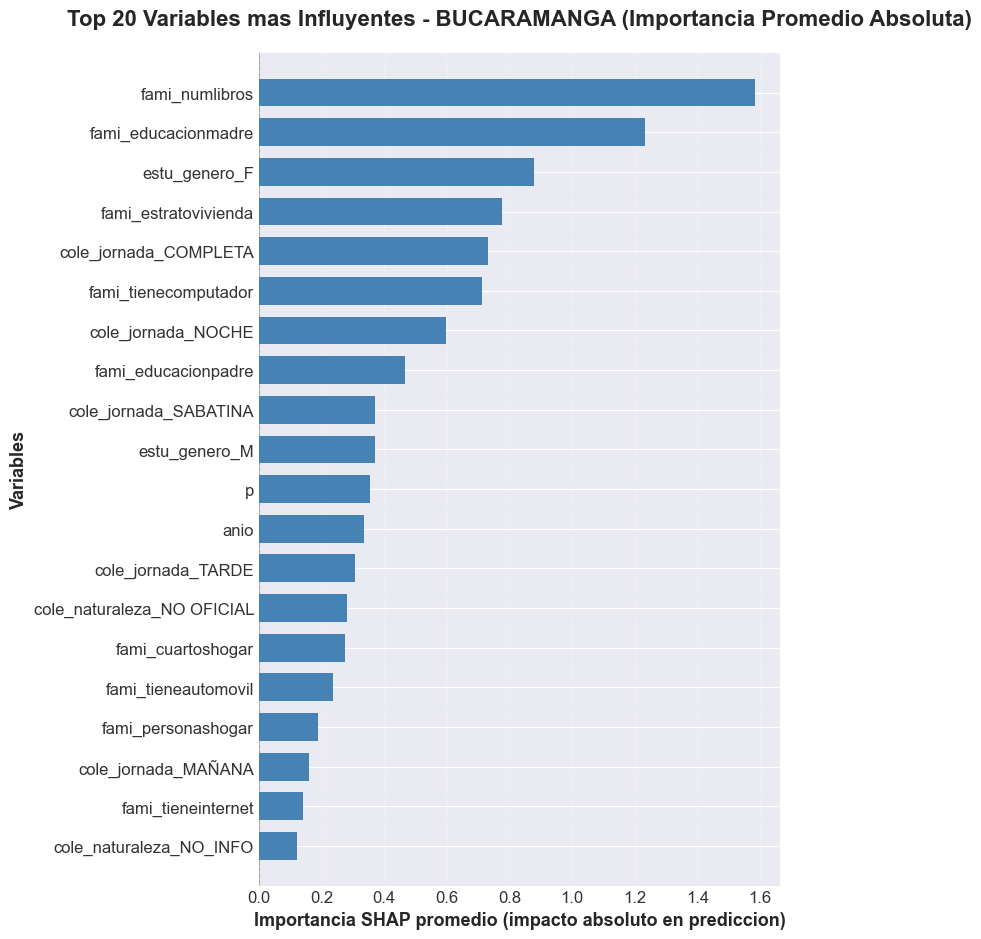

Grafico 1 generado: Importancia promedio (barras)


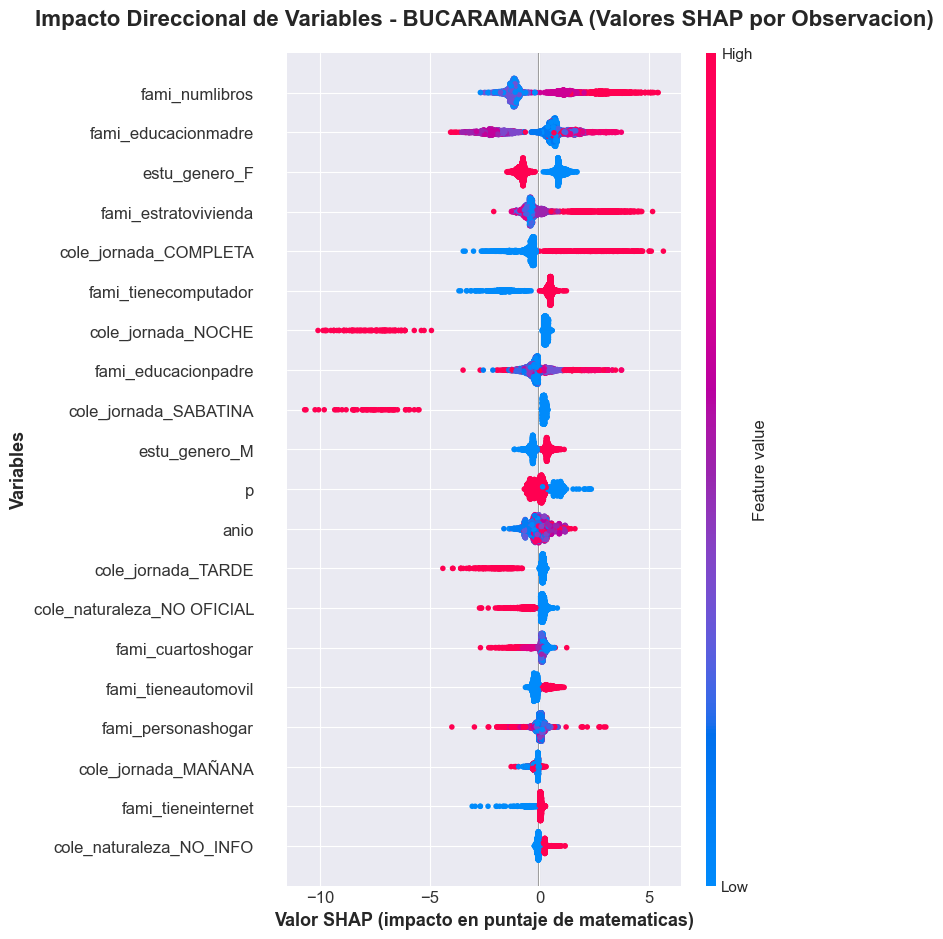

Grafico 2 generado: Impacto direccional (colores)
TOP 20 VARIABLES MAS INFLUYENTES - BUCARAMANGA
Rank   Variable                                           Importancia SHAP     % del total    
-----------------------------------------------------------------------------------------------
1      fami_numlibros                                     1.584802             14.84          %
2      fami_educacionmadre                                1.232289             11.54          %
3      estu_genero_F                                      0.878426             8.22           %
4      fami_estratovivienda                               0.776520             7.27           %
5      cole_jornada_COMPLETA                              0.731292             6.85           %
6      fami_tienecomputador                               0.713990             6.68           %
7      cole_jornada_NOCHE                                 0.598343             5.60           %
8      fami_educacionpadre              

In [15]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

print("="*70)
print("ANALISIS SHAP - BUCARAMANGA")
print("="*70)

# Crear DataFrame de pandas con nombres de columnas para SHAP
X_train_bga_df = pd.DataFrame(X_train_bga, columns=feature_names_bga)
X_test_bga_df = pd.DataFrame(X_test_bga, columns=feature_names_bga)

# Crear modelo auxiliar de scikit-learn para compatibilidad con SHAP
print()
print("Creando modelo auxiliar para analisis SHAP...")
print("   (Configuracion basada en mejores parametros de Spark)")
gb_sklearn_bga = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=5
)

print()
print("Entrenando modelo auxiliar (esto toma ~1 min)...")
gb_sklearn_bga.fit(X_train_bga_df, y_train_bga)
print("Modelo auxiliar entrenado")

# Crear explainer SHAP
print()
print("Creando TreeExplainer para Bucaramanga...")
explainer_bga = shap.TreeExplainer(gb_sklearn_bga)

# Calcular valores SHAP
print("Calculando valores SHAP (esto puede tomar 1-2 minutos)...")
shap_values_bga = explainer_bga.shap_values(X_test_bga_df)

print(f"Valores SHAP calculados: {shap_values_bga.shape[0]} observaciones x {shap_values_bga.shape[1]} features")

# Visualizacion con nombres de variables
print()
print("Generando graficos de importancia...")
print()

# ============================================================================
# GRAFICO 1: Importancia promedio absoluta (barras)
# ============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
fig1, ax1 = plt.subplots(figsize=(14, 10))

plt.sca(ax1)
shap.summary_plot(shap_values_bga, X_test_bga_df, plot_type="bar", max_display=20,
                  show=False, color='steelblue')
ax1.set_title("Top 20 Variables mas Influyentes - BUCARAMANGA (Importancia Promedio Absoluta)",
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Importancia SHAP promedio (impacto absoluto en prediccion)",
               fontsize=13, fontweight='bold')
ax1.set_ylabel("Variables", fontsize=13, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('shap_bucaramanga_barras.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Grafico 1 generado: Importancia promedio (barras)")

# ============================================================================
# GRAFICO 2: Impacto direccional (puntos de colores)
# ============================================================================
fig2, ax2 = plt.subplots(figsize=(14, 10))

plt.sca(ax2)
shap.summary_plot(shap_values_bga, X_test_bga_df, max_display=20, show=False)
ax2.set_title("Impacto Direccional de Variables - BUCARAMANGA (Valores SHAP por Observacion)",
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel("Valor SHAP (impacto en puntaje de matematicas)",
               fontsize=13, fontweight='bold')
ax2.set_ylabel("Variables", fontsize=13, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('shap_bucaramanga_impacto.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Grafico 2 generado: Impacto direccional (colores)")

# ============================================================================
# TABLA DE IMPORTANCIAS
# ============================================================================
mean_abs_shap_bga = np.abs(shap_values_bga).mean(axis=0)
importance_df_bga = pd.DataFrame({
    'variable': feature_names_bga,
    'importancia_shap': mean_abs_shap_bga
}).sort_values('importancia_shap', ascending=False)

top_20_bga = importance_df_bga.head(20)

print("="*95)
print("TOP 20 VARIABLES MAS INFLUYENTES - BUCARAMANGA")
print("="*95)
print(f"{'Rank':<6} {'Variable':<50} {'Importancia SHAP':<20} {'% del total':<15}")
print("-"*95)
total_importance = mean_abs_shap_bga.sum()
for idx, (_, row) in enumerate(top_20_bga.iterrows(), 1):
    pct = (row['importancia_shap'] / total_importance) * 100
    print(f"{idx:<6} {row['variable']:<50} {row['importancia_shap']:<20.6f} {pct:<15.2f}%")

print("Graficos guardados:")
print("   - shap_bucaramanga_barras.png")
print("   - shap_bucaramanga_impacto.png")
print("="*95)


### 7.3 Análisis SHAP - Santa Marta

Calculamos y visualizamos los valores SHAP para identificar las variables más influyentes en el rendimiento académico en Santa Marta.

ANALISIS SHAP - SANTA MARTA

Creando modelo auxiliar para analisis SHAP...
   (Configuracion basada en mejores parametros de Spark)

Entrenando modelo auxiliar (esto toma ~1 min)...
Modelo auxiliar entrenado

Creando TreeExplainer para Santa Marta...
Calculando valores SHAP (esto puede tomar 1-2 minutos)...
Valores SHAP calculados: 2959 observaciones x 30 features

Generando graficos de importancia...



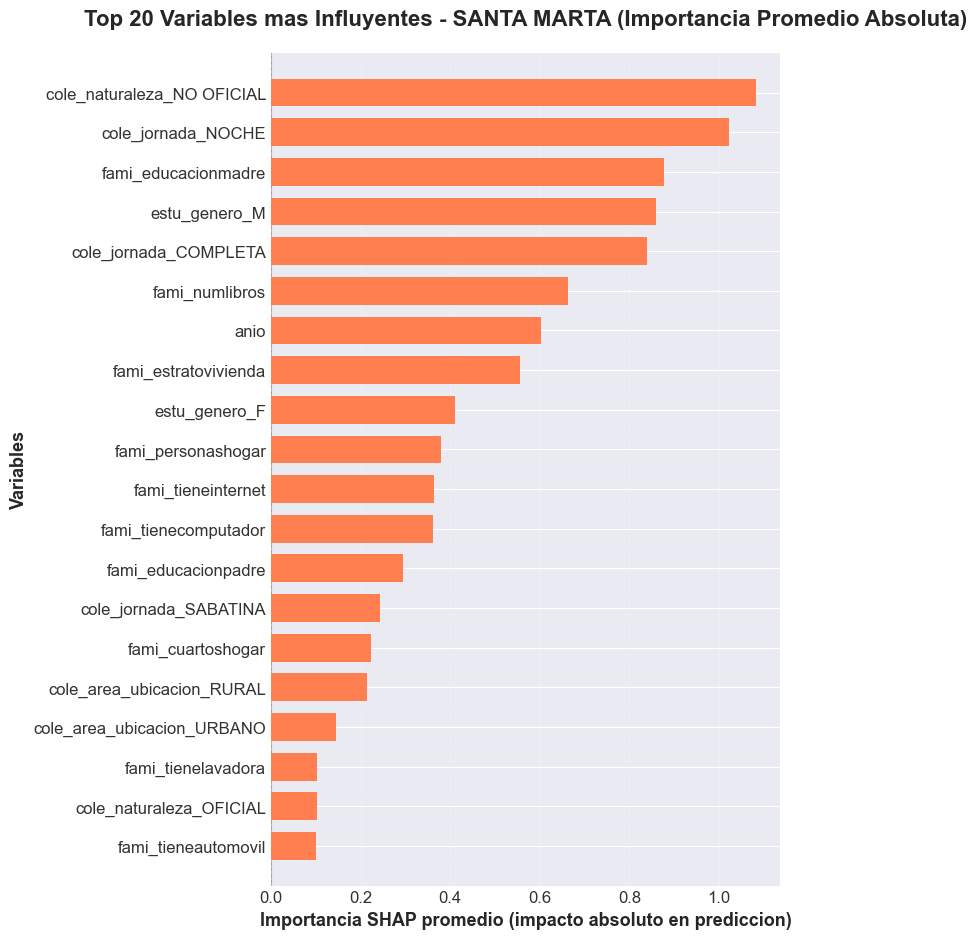

Grafico 1 generado: Importancia promedio (barras)


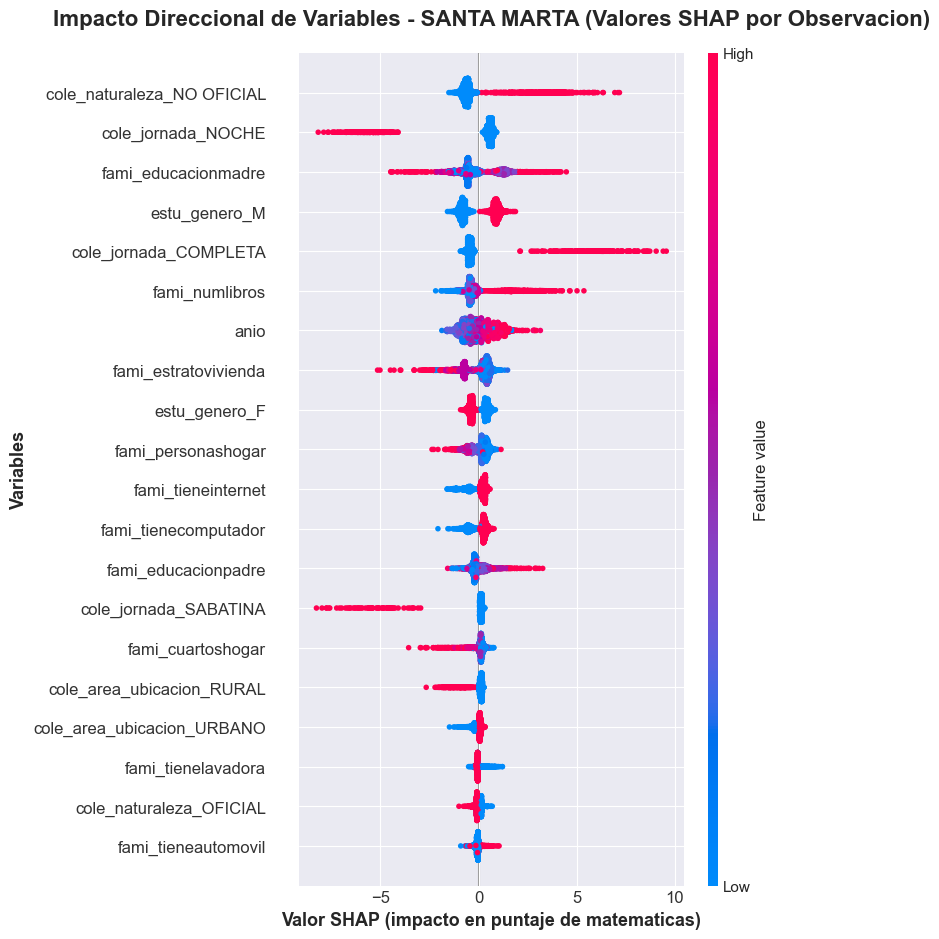

Grafico 2 generado: Impacto direccional (colores)
TOP 20 VARIABLES MAS INFLUYENTES - SANTA MARTA
Rank   Variable                                           Importancia SHAP     % del total    
-----------------------------------------------------------------------------------------------
1      cole_naturaleza_NO OFICIAL                         1.082130             11.13          %
2      cole_jornada_NOCHE                                 1.023420             10.52          %
3      fami_educacionmadre                                0.876180             9.01           %
4      estu_genero_M                                      0.859830             8.84           %
5      cole_jornada_COMPLETA                              0.839182             8.63           %
6      fami_numlibros                                     0.663560             6.82           %
7      anio                                               0.603377             6.20           %
8      fami_estratovivienda             

In [16]:
print("="*70)
print("ANALISIS SHAP - SANTA MARTA")
print("="*70)

# Crear DataFrame de pandas con nombres de columnas para SHAP
X_train_stm_df = pd.DataFrame(X_train_stm, columns=feature_names_stm)
X_test_stm_df = pd.DataFrame(X_test_stm, columns=feature_names_stm)

# Crear modelo auxiliar de scikit-learn para compatibilidad con SHAP
print()
print("Creando modelo auxiliar para analisis SHAP...")
print("   (Configuracion basada en mejores parametros de Spark)")
gb_sklearn_stm = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=5
)

print()
print("Entrenando modelo auxiliar (esto toma ~1 min)...")
gb_sklearn_stm.fit(X_train_stm_df, y_train_stm)
print("Modelo auxiliar entrenado")

# Crear explainer SHAP
print()
print("Creando TreeExplainer para Santa Marta...")
explainer_stm = shap.TreeExplainer(gb_sklearn_stm)

# Calcular valores SHAP
print("Calculando valores SHAP (esto puede tomar 1-2 minutos)...")
shap_values_stm = explainer_stm.shap_values(X_test_stm_df)

print(f"Valores SHAP calculados: {shap_values_stm.shape[0]} observaciones x {shap_values_stm.shape[1]} features")

# Visualizacion con nombres de variables
print()
print("Generando graficos de importancia...")
print()

# ============================================================================
# GRAFICO 1: Importancia promedio absoluta (barras)
# ============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
fig1, ax1 = plt.subplots(figsize=(14, 10))

plt.sca(ax1)
shap.summary_plot(shap_values_stm, X_test_stm_df, plot_type="bar", max_display=20,
                  show=False, color='coral')
ax1.set_title("Top 20 Variables mas Influyentes - SANTA MARTA (Importancia Promedio Absoluta)",
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Importancia SHAP promedio (impacto absoluto en prediccion)",
               fontsize=13, fontweight='bold')
ax1.set_ylabel("Variables", fontsize=13, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('shap_santamarta_barras.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Grafico 1 generado: Importancia promedio (barras)")

# ============================================================================
# GRAFICO 2: Impacto direccional (puntos de colores)
# ============================================================================
fig2, ax2 = plt.subplots(figsize=(14, 10))

plt.sca(ax2)
shap.summary_plot(shap_values_stm, X_test_stm_df, max_display=20, show=False)
ax2.set_title("Impacto Direccional de Variables - SANTA MARTA (Valores SHAP por Observacion)",
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel("Valor SHAP (impacto en puntaje de matematicas)",
               fontsize=13, fontweight='bold')
ax2.set_ylabel("Variables", fontsize=13, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('shap_santamarta_impacto.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Grafico 2 generado: Impacto direccional (colores)")

# ============================================================================
# TABLA DE IMPORTANCIAS
# ============================================================================
mean_abs_shap_stm = np.abs(shap_values_stm).mean(axis=0)
importance_df_stm = pd.DataFrame({
    'variable': feature_names_stm,
    'importancia_shap': mean_abs_shap_stm
}).sort_values('importancia_shap', ascending=False)

top_20_stm = importance_df_stm.head(20)

print("="*95)
print("TOP 20 VARIABLES MAS INFLUYENTES - SANTA MARTA")
print("="*95)
print(f"{'Rank':<6} {'Variable':<50} {'Importancia SHAP':<20} {'% del total':<15}")
print("-"*95)
total_importance = mean_abs_shap_stm.sum()
for idx, (_, row) in enumerate(top_20_stm.iterrows(), 1):
    pct = (row['importancia_shap'] / total_importance) * 100
    print(f"{idx:<6} {row['variable']:<50} {row['importancia_shap']:<20.6f} {pct:<15.2f}%")

print("Graficos guardados:")
print("   - shap_santamarta_barras.png")
print("   - shap_santamarta_impacto.png")
print("="*95)


### 7.4 Comparación SHAP: Bucaramanga vs Santa Marta

Esta subsección consolida los resultados de SHAP de ambos municipios para identificar patrones comunes y diferencias en la importancia de las variables socioeconómicas.

ANALISIS COMPARATIVO DE IMPORTANCIAS SHAP

TOP 20 VARIABLES POR IMPORTANCIA PROMEDIO:

Rank   Variable                                      Bga            Stm            Diferencia    
-----------------------------------------------------------------------------------------------
1      fami_numlibros                                1.584802       0.663560       +0.921242      
2      fami_educacionmadre                           1.232289       0.876180       +0.356109      
3      cole_jornada_NOCHE                            0.598343       1.023420       -0.425077     
4      cole_jornada_COMPLETA                         0.731292       0.839182       -0.107890     
5      cole_naturaleza_NO OFICIAL                    0.280752       1.082130       -0.801379     
6      fami_estratovivienda                          0.776520       0.555418       +0.221102      
7      estu_genero_F                                 0.878426       0.409453       +0.468973      
8      estu_genero_M         

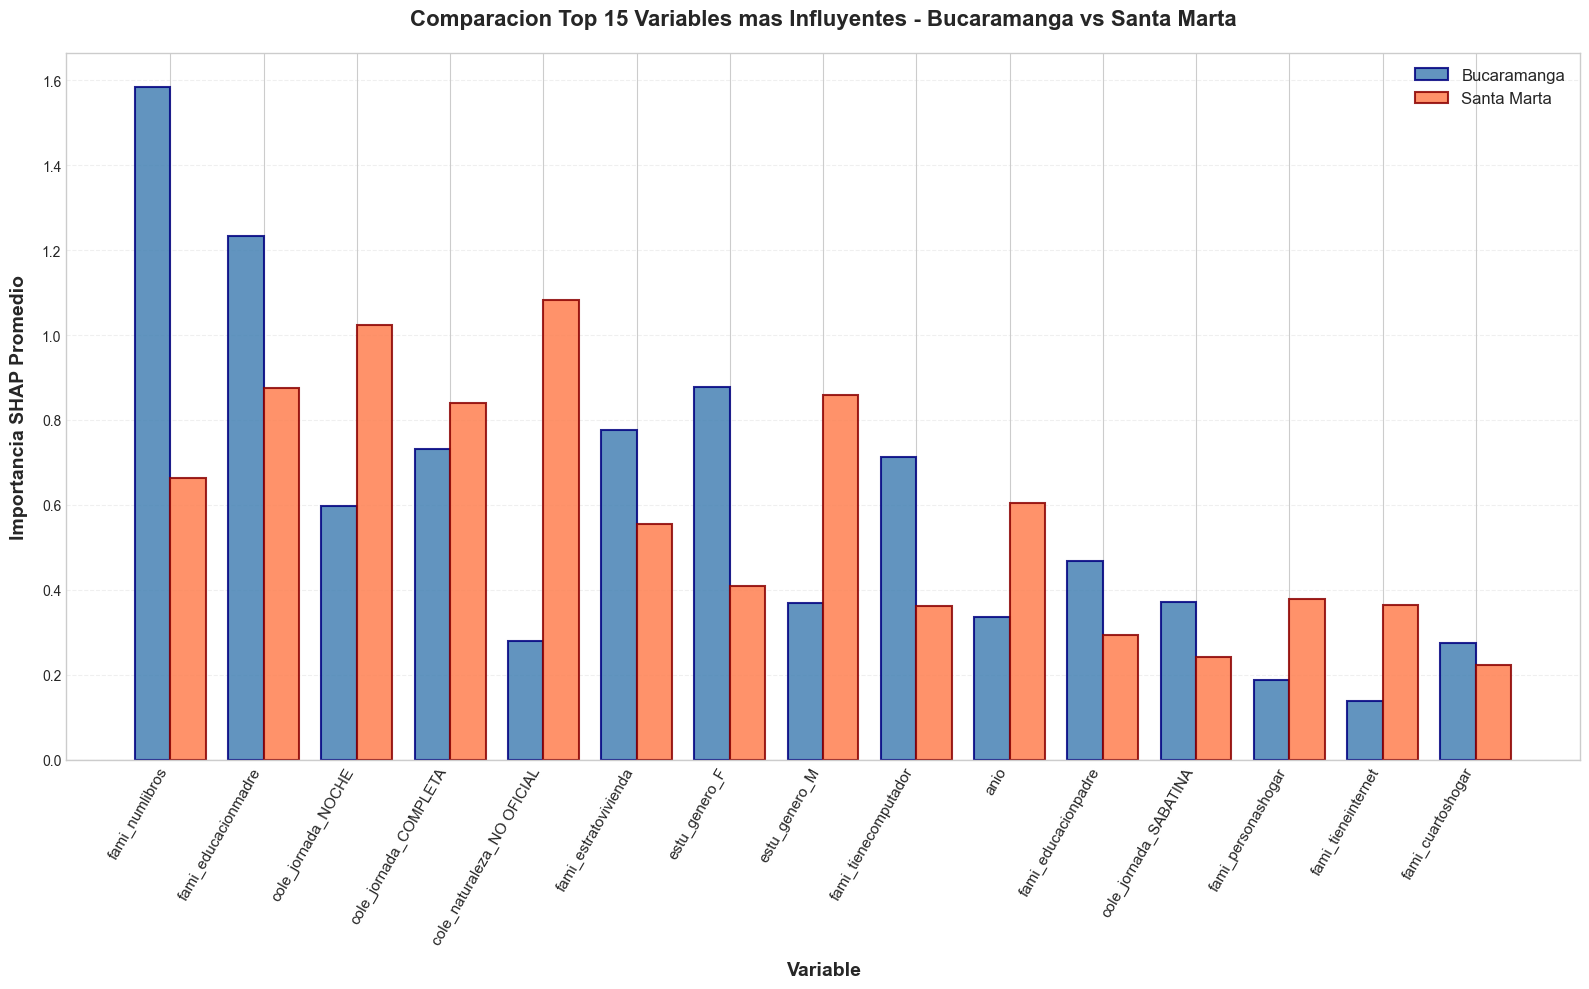


Grafico comparativo guardado como: shap_comparison.png
Tabla comparativa guardada como: shap_comparison_bucaramanga_vs_santamarta.csv


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("="*70)
print("ANALISIS COMPARATIVO DE IMPORTANCIAS SHAP")
print("="*70)

importance_bga = importance_df_bga.rename(
    columns={'importancia_shap': 'importancia_bucaramanga'}
)
importance_stm = importance_df_stm.rename(
    columns={'importancia_shap': 'importancia_santamarta'}
)

# Crear DataFrame comparativo con nombres de variables (alineado por nombre)
comparison_df = pd.merge(
    importance_bga,
    importance_stm,
    on='variable',
    how='outer'
).fillna(0)

# Calcular diferencias
comparison_df['diferencia_absoluta'] = (
    comparison_df['importancia_bucaramanga'] -
    comparison_df['importancia_santamarta']
)

comparison_df['diferencia_relativa'] = (
    comparison_df['diferencia_absoluta'] /
    (comparison_df[['importancia_bucaramanga', 'importancia_santamarta']].max(axis=1) + 1e-10)
)

comparison_df['abs_diferencia'] = comparison_df['diferencia_absoluta'].abs()

# Ordenar por importancia promedio
comparison_df['importancia_promedio'] = (
    comparison_df['importancia_bucaramanga'] +
    comparison_df['importancia_santamarta']
) / 2

comparison_df = comparison_df.sort_values('importancia_promedio', ascending=False)

# Top 20 variables mas importantes en promedio
top_20_diff = comparison_df.head(20)

print()
print("TOP 20 VARIABLES POR IMPORTANCIA PROMEDIO:")
print()
print(f"{'Rank':<6} {'Variable':<45} {'Bga':<14} {'Stm':<14} {'Diferencia':<14}")
print("-"*95)
for idx, (_, row) in enumerate(top_20_diff.iterrows(), 1):
    signo = '+' if row['diferencia_absoluta'] > 0 else ''
    print(f"{idx:<6} {row['variable']:<45} {row['importancia_bucaramanga']:<14.6f} "
          f"{row['importancia_santamarta']:<14.6f} {signo}{row['diferencia_absoluta']:<14.6f}")

# Variables con mayor diferencia relativa
print()
print("="*95)
print("VARIABLES CON MAYOR DIFERENCIA ENTRE CIUDADES")
print("="*95)

# Filtrar variables significativas (importancia > percentil 50)
umbral = comparison_df['importancia_promedio'].quantile(0.5)
vars_significativas = comparison_df[comparison_df['importancia_promedio'] > umbral]
vars_diferentes = vars_significativas.nlargest(10, 'abs_diferencia')

print()
print("Top 10 variables con mayor diferencia (entre las mas importantes):")
print()
print(f"{'Variable':<45} {'Bga':<14} {'Stm':<14} {'Dif%':<12} {'Mas importante en':<20}")
print("-"*100)
for _, row in vars_diferentes.iterrows():
    pct = row['diferencia_relativa'] * 100
    signo = 'Bucaramanga' if row['diferencia_absoluta'] > 0 else 'Santa Marta'
    print(f"{row['variable']:<45} {row['importancia_bucaramanga']:<14.6f} "
          f"{row['importancia_santamarta']:<14.6f} {abs(pct):<12.1f}% {signo:<20}")

# Identificar variables distintivas de cada ciudad
umbral_diferencia = comparison_df['abs_diferencia'].quantile(0.80)
vars_distintivas_bga = comparison_df[
    (comparison_df['diferencia_absoluta'] > 0) &
    (comparison_df['abs_diferencia'] >= umbral_diferencia)
]['variable'].tolist()

vars_distintivas_stm = comparison_df[
    (comparison_df['diferencia_absoluta'] < 0) &
    (comparison_df['abs_diferencia'] >= umbral_diferencia)
]['variable'].tolist()

print()
print("="*95)
print("VARIABLES DISTINTIVAS POR CIUDAD (Percentil 80+ en diferencia)")
print("="*95)
print()
print(f"Mas importantes en BUCARAMANGA ({len(vars_distintivas_bga)} variables):")
for i, var in enumerate(vars_distintivas_bga[:10], 1):
    val_bga = comparison_df[comparison_df['variable'] == var]['importancia_bucaramanga'].values[0]
    val_stm = comparison_df[comparison_df['variable'] == var]['importancia_santamarta'].values[0]
    print(f"   {i:2d}. {var:<40} (Bga: {val_bga:.4f} | Stm: {val_stm:.4f})")

print()
print(f"Mas importantes en SANTA MARTA ({len(vars_distintivas_stm)} variables):")
for i, var in enumerate(vars_distintivas_stm[:10], 1):
    val_bga = comparison_df[comparison_df['variable'] == var]['importancia_bucaramanga'].values[0]
    val_stm = comparison_df[comparison_df['variable'] == var]['importancia_santamarta'].values[0]
    print(f"   {i:2d}. {var:<40} (Bga: {val_bga:.4f} | Stm: {val_stm:.4f})")

# Visualizacion comparativa mejorada
print()
print("Generando grafico comparativo...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 10))

# Grafico de barras comparativo para top 15
top_15 = comparison_df.head(15)
x = np.arange(len(top_15))
width = 0.38

bars1 = ax.bar(x - width/2, top_15['importancia_bucaramanga'], width,
               label='Bucaramanga', alpha=0.85, color='steelblue', edgecolor='navy', linewidth=1.5)
bars2 = ax.bar(x + width/2, top_15['importancia_santamarta'], width,
               label='Santa Marta', alpha=0.85, color='coral', edgecolor='darkred', linewidth=1.5)

# Personalizacion del grafico
ax.set_xlabel('Variable', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Importancia SHAP Promedio', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('Comparacion Top 15 Variables mas Influyentes - Bucaramanga vs Santa Marta',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top_15['variable'].values, rotation=60, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right', framealpha=0.9, edgecolor='black')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Anadir lineas de referencia
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.3)

# Ajustar margenes
plt.tight_layout()
plt.savefig('shap_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Guardar tabla comparativa
comparison_df.to_csv('shap_comparison_bucaramanga_vs_santamarta.csv', index=False)

print()
print("Grafico comparativo guardado como: shap_comparison.png")
print("Tabla comparativa guardada como: shap_comparison_bucaramanga_vs_santamarta.csv")
print("="*95)


## 8. Análisis de Errores de Predicción

Evaluación de la calidad y distribución de los errores de predicción para los mejores modelos de cada municipio.

ANÁLISIS COMPARATIVO DE ERRORES: BUCARAMANGA VS SANTA MARTA

🏆 Mejor modelo Bucaramanga: Random Forest
🏆 Mejor modelo Santa Marta: Random Forest


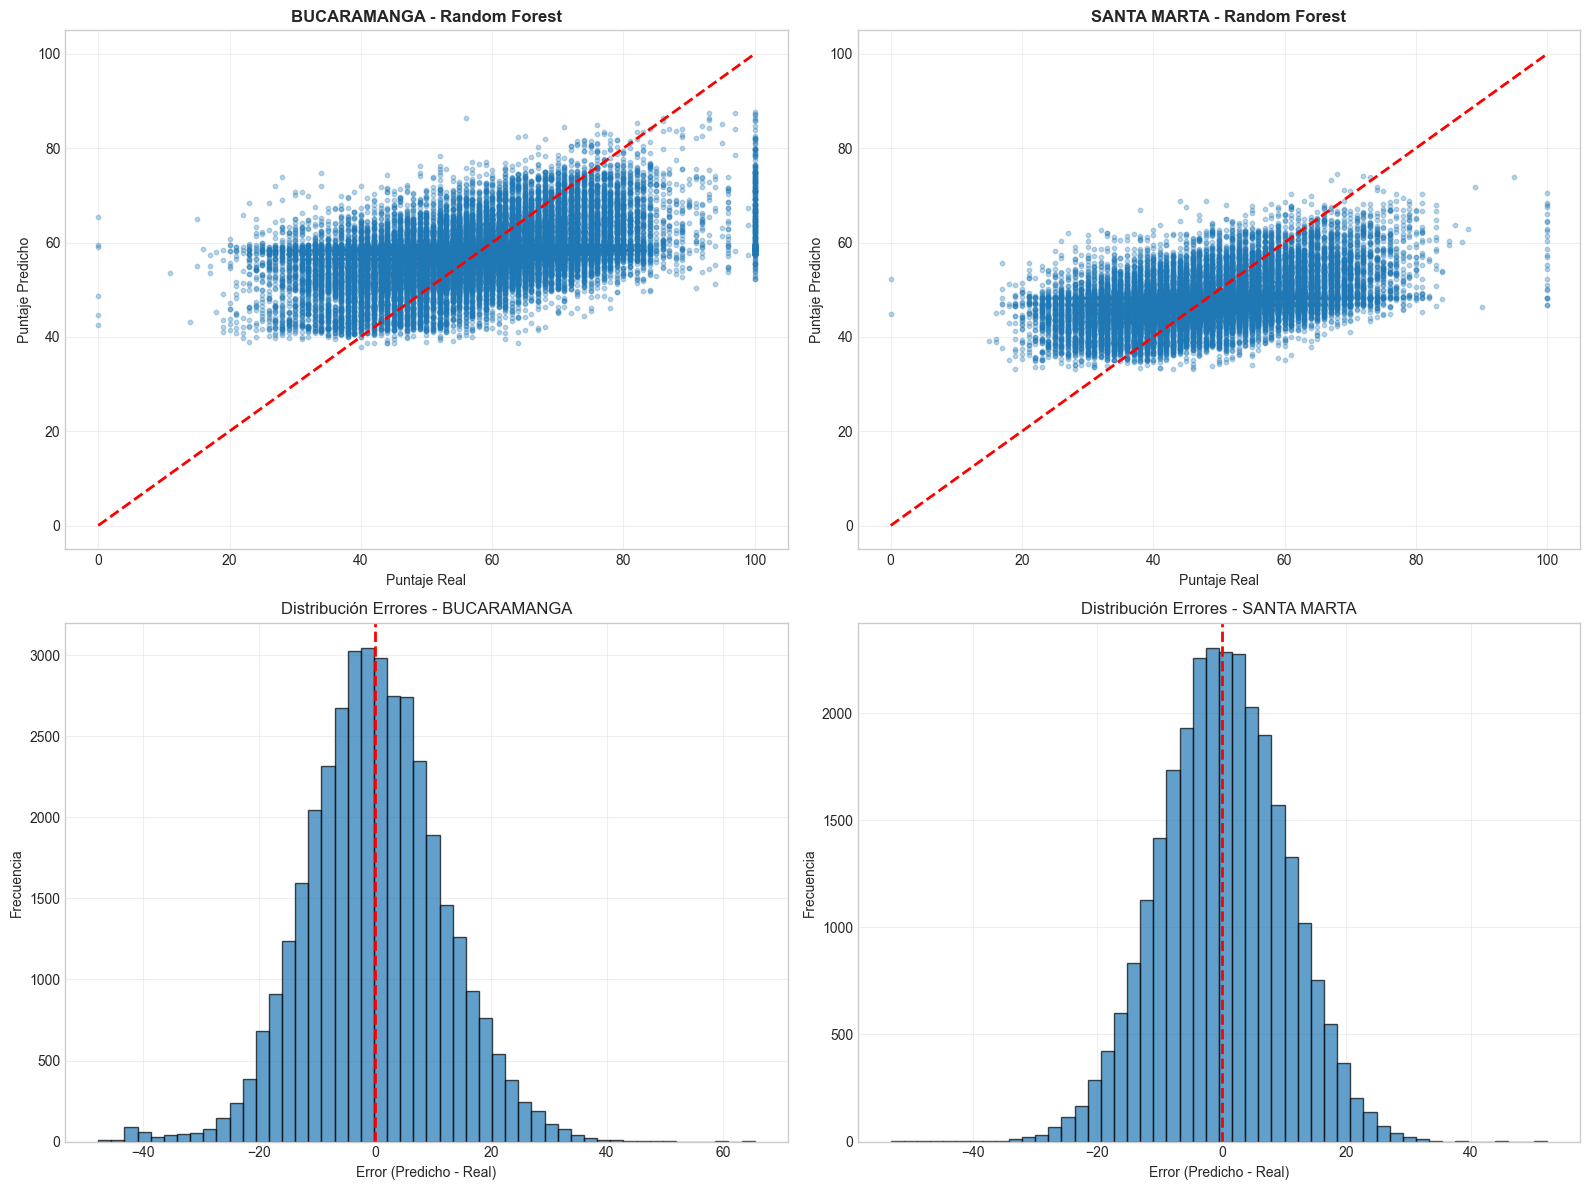


📊 ESTADÍSTICAS DE ERRORES:

Ciudad                 Media     Desv.Std          MAE
----------------------------------------------------
Bucaramanga           0.0101      11.6365       9.1089
Santa Marta           0.0986      10.0437       7.9979

✅ Análisis de errores completado


In [18]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

print("="*70)
print("ANÁLISIS COMPARATIVO DE ERRORES: BUCARAMANGA VS SANTA MARTA")
print("="*70)

# Determinar mejor modelo de cada ciudad
mejor_idx_bga = resultados_bucaramanga['r2_test'].idxmax()
mejor_idx_stm = resultados_santamarta['r2_test'].idxmax()

mejor_bga_nombre = resultados_bucaramanga.loc[mejor_idx_bga, 'modelo']
mejor_stm_nombre = resultados_santamarta.loc[mejor_idx_stm, 'modelo']

print(f"\n🏆 Mejor modelo Bucaramanga: {mejor_bga_nombre}")
print(f"🏆 Mejor modelo Santa Marta: {mejor_stm_nombre}")

# Seleccionar predicciones según el mejor modelo
if mejor_bga_nombre == 'Gradient Boosting':
    pred_bga = gbt_predictions_test_bga
elif mejor_bga_nombre == 'Random Forest':
    pred_bga = rf_predictions_test_bga
else:
    pred_bga = test_pred_lr_bga

if mejor_stm_nombre == 'Gradient Boosting':
    pred_stm = gbt_predictions_test_stm
elif mejor_stm_nombre == 'Random Forest':
    pred_stm = rf_predictions_test_stm
else:
    pred_stm = test_pred_lr_stm

# Calcular errores
pred_bga = pred_bga.withColumn('error', F.col('prediction') - F.col('label'))
pred_stm = pred_stm.withColumn('error', F.col('prediction') - F.col('label'))

# Convertir a Pandas para visualización
errors_bga_pd = pred_bga.select('label', 'prediction', 'error').toPandas()
errors_stm_pd = pred_stm.select('label', 'prediction', 'error').toPandas()

# Gráficos comparativos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Fila 1: Predicciones vs Reales
axes[0,0].scatter(errors_bga_pd['label'], errors_bga_pd['prediction'], alpha=0.3, s=10)
axes[0,0].plot([errors_bga_pd['label'].min(), errors_bga_pd['label'].max()], 
               [errors_bga_pd['label'].min(), errors_bga_pd['label'].max()], 
               'r--', lw=2)
axes[0,0].set_xlabel('Puntaje Real')
axes[0,0].set_ylabel('Puntaje Predicho')
axes[0,0].set_title(f'BUCARAMANGA - {mejor_bga_nombre}', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(errors_stm_pd['label'], errors_stm_pd['prediction'], alpha=0.3, s=10)
axes[0,1].plot([errors_stm_pd['label'].min(), errors_stm_pd['label'].max()], 
               [errors_stm_pd['label'].min(), errors_stm_pd['label'].max()], 
               'r--', lw=2)
axes[0,1].set_xlabel('Puntaje Real')
axes[0,1].set_ylabel('Puntaje Predicho')
axes[0,1].set_title(f'SANTA MARTA - {mejor_stm_nombre}', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Fila 2: Distribución de Errores
axes[1,0].hist(errors_bga_pd['error'], bins=50, edgecolor='black', alpha=0.7)
axes[1,0].axvline(0, color='red', linestyle='--', lw=2)
axes[1,0].set_xlabel('Error (Predicho - Real)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title(f'Distribución Errores - BUCARAMANGA')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].hist(errors_stm_pd['error'], bins=50, edgecolor='black', alpha=0.7)
axes[1,1].axvline(0, color='red', linestyle='--', lw=2)
axes[1,1].set_xlabel('Error (Predicho - Real)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title(f'Distribución Errores - SANTA MARTA')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de errores
print("\n📊 ESTADÍSTICAS DE ERRORES:\n")
print(f"{'Ciudad':<15} {'Media':>12} {'Desv.Std':>12} {'MAE':>12}")
print("-"*52)
print(f"{'Bucaramanga':<15} {errors_bga_pd['error'].mean():>12.4f} "
      f"{errors_bga_pd['error'].std():>12.4f} "
      f"{errors_bga_pd['error'].abs().mean():>12.4f}")
print(f"{'Santa Marta':<15} {errors_stm_pd['error'].mean():>12.4f} "
      f"{errors_stm_pd['error'].std():>12.4f} "
      f"{errors_stm_pd['error'].abs().mean():>12.4f}")

print("\n✅ Análisis de errores completado")
print("="*70)